# Exploring the predictive skill of Reask Metryc footprints in estimating timing, magnitude, and spatial distribution of emergency call spikes before, during, and/or after a hurricane

Author: Ian Bolliger, Reask  
Contact: ian@reask.earth  
Last Updated: Nov 14, 2024

This notebook contains a proof-of-concept analysis, showing how Reask [Metryc](https://reask.earth/products/#Metryc) wind footprints can help predict the timing and magnitude of spikes in emergency calls before, during, and after a hurricane. It serves as the underlying analysis behind the blog post about this effort available [INSERT LINK].

**Note:** This analysis notebook is provided for transparency, but please note that it is not fully documented and will not be runnable without access to the Reask API and proprietary normalized and anonymized emergency call data from [RapidSOS](https://rapidsos.com). If you would like to discuss access to either of these datasets, please reach out to contact@reask.earth or visit https://rapidsos.com/contact, respectively.

**Additional Data Used**

In addition to Metryc footprints and emergency call data, this notebook relies on a few other publicly available datasets.

* Population by [H3 R8](https://h3geo.org) unit comes from https://data.humdata.org/dataset/kontur-population-united-states-of-america. This is used to normalize call counts per capita.

* County shapefiles come from https://www2.census.gov/geo/tiger/TIGER2024/COUNTY/. These are used to aggregate call counts for specific counties for visualization purposes.

* Hurricane track information comes from [IBTrACS](https://www.ncei.noaa.gov/products/international-best-track-archive). This is used to determine time at which each storm was closest to each hexagon.

* A previously created dataset of buffered storm tracks was used to select the spatial extent of emergency call data obtained from RapidSOS. These are used here again to filter some outlier call observations that contained erroneous location data at the start of the call that place them outside of the buffer.

## Setup

In [1]:
from io import BytesIO
from pathlib import Path

import cartopy.io.shapereader as shpreader
import colorcet  # noqa: F401
import geopandas as gpd
import h3
import numpy as np
import pandas as pd
import rioxarray as rio
import seaborn as sns
import shapely as shp
import statsmodels.formula.api as smf
import xarray as xr
from cartopy import crs as ccrs
from matplotlib import colors, rcParams
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.neighbors import BallTree

from reaskapi.metryc import Metryc

idx = pd.IndexSlice
sns.set("paper", style="dark")

### Parameters

In [2]:
FIG_DPI = 300
TIMING_KIND = "nearest"
N_BASELINE_WKS = 3
HOME_DIR = Path("/Users/ianbolliger/OneDrive - REASK PTY LTD/projects/rapidsos/")

DATA_DIR = HOME_DIR / "input-data"
FIG_DIR = HOME_DIR / "milton-figs"

In [3]:
FIG_DIR.mkdir(exist_ok=True)
rcParams["figure.dpi"] = FIG_DPI

### Reask API initialization

In [4]:
client = Metryc()

2024-11-14 12:35:10,048 - INFO - reaskapi.auth:31 - Authenticating


## Load data

### Population by hexagon

In [5]:
pop_file = DATA_DIR / "kontur_population_US_20231101.gpkg"

all_pops = gpd.read_file(pop_file).set_index("h3").to_crs("EPSG:4326")
all_pops.head()

population                                           geometry
h3                                                                            
889b896ce7fffff        95.0  POLYGON ((-169.61877 -14.18172, -169.61521 -14...
889b896ce3fffff         5.0  POLYGON ((-169.62723 -14.18432, -169.62366 -14...
889b896ce1fffff        18.0  POLYGON ((-169.62101 -14.18993, -169.61745 -14...
889b896cd3fffff        20.0  POLYGON ((-169.66725 -14.18911, -169.66369 -14...
889b896cabfffff         5.0  POLYGON ((-169.6312 -14.17051, -169.62764 -14....

### County shapes

In [6]:
county_file = DATA_DIR / "tl_2024_us_county"

counties = gpd.read_file(county_file, columns=["NAME", "GEOID"]).to_crs("EPSG:4326")
assert counties.GEOID.is_unique
land_poly = counties.union_all()
counties.head()

GEOID       NAME                                           geometry
0  31039     Cuming  POLYGON ((-96.55525 41.82892, -96.55524 41.827...
1  53069  Wahkiakum  POLYGON ((-123.72756 46.26449, -123.72756 46.2...
2  35011    De Baca  POLYGON ((-104.89337 34.08894, -104.89337 34.0...
3  31109  Lancaster  POLYGON ((-96.68493 40.52329, -96.69219 40.523...
4  31129   Nuckolls  POLYGON ((-98.2737 40.1184, -98.27374 40.1224,...

### Landfall times

In [7]:
landfall_times = {
    "beryl": "07-08-2024T09:00:00",
    "ida": "08-29-2021T16:00:00",
    "idalia": "08-30-2023T11:00:00",
    "ian": "09-28-2022T20:00:00",
    "milton": "10-10-2024T03:00:00",
}
landfall_times = pd.to_datetime(
    pd.Series(landfall_times).rename_axis("storm"), utc=True
)
landfall_times

storm
beryl    2024-07-08 09:00:00+00:00
ida      2021-08-29 16:00:00+00:00
idalia   2023-08-30 11:00:00+00:00
ian      2022-09-28 20:00:00+00:00
milton   2024-10-10 03:00:00+00:00
dtype: datetime64[ns, UTC]

### IBTrACS

In [8]:
ibt_file = DATA_DIR / "IBTrACS.ALL.v04r01.nc"
ibt = xr.open_dataset(ibt_file)

In [9]:
sids = {
    "beryl": "2024178N09335",  # 10/14/2024: waiting on NCEI to come back online to re-download IBTrACS to have 2024 data
    "ida": "2021239N17281",
    "idalia": "2023239N21274",
    "ian": "2022266N12294",
    "milton": "2024278N21265",
}

ibt_file = DATA_DIR / "IBTrACS.ALL.v04r01.nc"
ibt = xr.open_dataset(ibt_file)
ibt = ibt.swap_dims(storm="sid").sel(sid=[i.encode() for i in sids.values()])[
    ["time", "lat", "lon"]
]
ibt["sid"] = ibt.sid.str.decode("utf-8")

ibt = ibt.to_dataframe().dropna()

# only use regular intervals
ibt = ibt[ibt.time.dt.minute == 0]
ibt["time"] = ibt.time.dt.round("h").dt.tz_localize("utc")

ibt = ibt.reset_index("date_time", drop=True).set_index("time", append=True)

ibt = gpd.GeoSeries.from_xy(ibt.lon, ibt.lat, crs="EPSG:4326")

# only land points
ibt = ibt[ibt.intersects(land_poly)]

### Buffers around storm track

In [10]:
storm_buffers = gpd.read_parquet(DATA_DIR / "storm_buffer_polygons.parquet").geometry

# add all of florida for Milton
storm_buffers["milton"] = (
    gpd.read_file(
        shpreader.natural_earth(
            resolution="110m",
            category="cultural",
            name="admin_1_states_provinces",
        )
    )
    .set_index("iso_3166_2")
    .loc["US-FL", "geometry"]
)

### Emergency call data location

In [11]:
sos_files = list(DATA_DIR.glob("*.csv"))
sos_files = {p.stem.split("_")[1]: p for p in sos_files}
sos_files

{'beryl': PosixPath('/Users/ianbolliger/OneDrive - REASK PTY LTD/projects/rapidsos/input-data/hurricane_beryl_calls_per_minute_h3_aggregation.csv'),
 'hilary': PosixPath('/Users/ianbolliger/OneDrive - REASK PTY LTD/projects/rapidsos/input-data/hurricane_hilary_calls_per_minute_h3_aggregation.csv'),
 'milton': PosixPath('/Users/ianbolliger/OneDrive - REASK PTY LTD/projects/rapidsos/input-data/hurricane_milton_calls_per_minute_h3_aggregation.csv'),
 'ida': PosixPath('/Users/ianbolliger/OneDrive - REASK PTY LTD/projects/rapidsos/input-data/hurricane_ida_calls_per_minute_h3_aggregation.csv'),
 'idalia': PosixPath('/Users/ianbolliger/OneDrive - REASK PTY LTD/projects/rapidsos/input-data/hurricane_idalia_calls_per_minute_h3_aggregation.csv'),
 'ian': PosixPath('/Users/ianbolliger/OneDrive - REASK PTY LTD/projects/rapidsos/input-data/hurricane_ian_calls_per_minute_h3_aggregation.csv')}

## Define I/O and transformation functions

In [12]:
def spherical_nearest_neighbor(df1, df2):
    """Find the index in df2 of the nearest point to each element in df1.

    Parameters
    ----------
    df1 : pandas.DataFrame
        Points that will be assigned great circle nearest neighbors from df2
    df2 : pandas.DataFrame
        Location of points within which to select data

    Returns
    -------
    nearest_indices : pandas.Series
        :py:class:`pandas.Series` of indices in df2 for the nearest entries to
        each row in df1, indexed by df1's index.
    """
    ball = BallTree(np.deg2rad(df2[["lat", "lon"]]), metric="haversine")
    dists, ixs = ball.query(np.deg2rad(df1[["lat", "lon"]]), return_distance=True)
    out = pd.DataFrame(
        {"dist": np.rad2deg(dists[:, 0]), "nearest": df2.index[ixs[:, 0]].values},
        index=df1.index,
    )
    return out.nearest


def load_call_data(storm_name):
    """Load emergency call data from RapidSOS."""
    df = pd.read_csv(sos_files[storm_name], parse_dates=["pt_dt_minute"])

    # fix timezone bug in input data (it's in Eastern though it says UTC)
    df["pt_dt_minute"] = (
        df.pt_dt_minute.dt.tz_convert(None)
        .dt.tz_localize("US/Eastern")
        .dt.tz_convert("UTC")
    )
    return df


def load_and_align_data(storm_name, time_grouping, grouper="maxs"):
    """Load call data and wind data, align, and preprocess for further analysis."""
    print(f"Processing {storm_name}...")
    df = load_call_data(storm_name)

    df = (
        df.assign(h3=lambda x: x.start_h3_r9.apply(h3.cell_to_parent))
        .groupby(["pt_dt_minute", "h3"])[["call_count"]]
        .sum()
        .join(all_pops.population, on="h3")
    )

    locs = (
        df.reset_index("h3")[["h3"]]
        .drop_duplicates()
        .assign(locs=lambda x: x.h3.apply(h3.cell_to_latlng))
        .set_index("h3")
        .assign(lon=lambda x: x.locs.str[1], lat=lambda x: x.locs.str[0])[
            ["lon", "lat"]
        ]
    )
    loc_pts = gpd.GeoSeries.from_xy(locs.lon, locs.lat, crs="EPSG:4326")

    # drop outliers outside of polygon
    loc_pts = loc_pts[loc_pts.intersects(storm_buffers[storm_name])]
    locs = locs.loc[loc_pts.index]
    df = df.loc[(slice(None), loc_pts.index), :]

    this_ibt = ibt.loc[sids[storm_name]]
    this_ibt = (
        pd.DataFrame({"lon": this_ibt.x, "lat": this_ibt.y})
        .resample("min")
        .interpolate()
    )

    nearest_time = (
        spherical_nearest_neighbor(locs, this_ibt)
        .rename("nearest_time")
        .dt.tz_localize("utc")
    )

    county_xwalk = gpd.sjoin(
        loc_pts.to_frame(), counties.set_index("GEOID")[["geometry"]]
    )

    if storm_name in ["beryl", "milton"]:
        endpoint_type = "live"
    else:
        endpoint_type = "historical"
    footprint = (
        rio.open_rasterio(
            BytesIO(
                getattr(client, f"{endpoint_type}_tcwind_footprint")(
                    locs.lat.min() - 0.1,
                    locs.lat.max() + 0.1,
                    locs.lon.min() - 0.1,
                    min(locs.lon.max() + 0.1, -65),
                    storm_name=storm_name,
                    storm_year=landfall_times.dt.year.loc[storm_name],
                )
            ),
            mask_and_scale=True,
        )
        .squeeze(drop=True)
        .rename("maxs")
        .load()
    )

    locs = locs.to_xarray()
    out = df.join(
        footprint.sel(x=locs.lon, y=locs.lat, method="nearest")
        .rename("maxs")
        .to_series(),
        on="h3",
    ).join(nearest_time, on="h3")

    def _time_grouping(x):
        """Normalize time relative to key storm point.

        Allow computed time index to be relative to landfall time or the time at which
        the storm track was closest to a given point.
        """
        if time_grouping == "ldf":
            return np.floor(
                (
                    x.index.get_level_values("pt_dt_minute")
                    - landfall_times.loc[storm_name]
                ).total_seconds()
                / 3600
            )
        elif time_grouping == "nearest":
            return np.floor(
                (
                    x.index.get_level_values("pt_dt_minute") - x.nearest_time
                ).dt.total_seconds()
                / 3600
            )
        raise ValueError(time_grouping)

    out = (
        out.assign(
            hour=_time_grouping,
        )
        .astype({"hour": "int16"})
        .groupby(["h3", "hour"])
        .agg({"call_count": "sum", "maxs": "first", "population": "first"})
        .join(county_xwalk, on="h3")
    )

    to_drop = out[out.population.isnull()]
    n_dropped = len(to_drop)
    n_calls_dropped = to_drop.call_count.sum()
    print(
        f"...Total hexagons dropped due to 0 population: {n_dropped} "
        f"({n_dropped / len(out):.0%})"
    )
    print(
        f"...Total calls dropped due to 0 population: {n_calls_dropped} "
        f"({n_calls_dropped / out.call_count.sum():.0%})"
    )
    out = out[out.population.notnull()]

    # groupby wind speed experienced
    out = xr.merge(
        (
            out[["call_count"]].to_xarray().fillna(0),
            out[["maxs", "population", "GEOID"]].groupby("h3").first().to_xarray(),
        )
    ).fillna({"maxs": -1})
    out = out.reindex(hour=np.arange(out.hour.min(), out.hour.max()), fill_value=0)
    out["call_count"] = out.call_count.astype("uint8")

    df_out = out.drop_vars("population").to_dataframe()

    df_out = (
        df_out.groupby(["hour", grouper, "GEOID"])
        .sum()
        .join(
            out.drop_dims("hour")
            .groupby([grouper, "GEOID"])
            .sum()
            .population.fillna(0)
            .to_series(),
            on=[grouper, "GEOID"],
        )
    )
    return (
        df_out.assign(storm=storm_name)
        .set_index("storm", append=True)
        .reorder_levels(["storm", "hour", "GEOID", grouper])
        .sort_index()
    )


def normalize_calls(calls, baseline_calls, how="ratio", fillna=1, fillinf=False):
    """Calculate call rate ratio (CRR) or call rate difference (CRD)."""
    if "day" in calls.index.names:
        divider = 7
        time_name = "day"

    elif "hour" in calls.index.names:
        divider = 24 * 7
        time_name = "hour"
    else:
        raise ValueError(calls.index.names)
    joined = (
        calls.to_frame()
        .assign(tmp=calls.index.get_level_values(time_name) % divider)
        .join(
            baseline_calls.rename("baseline"),
            on=[i if i != time_name else "tmp" for i in calls.index.names],
        )
    )

    if how == "ratio":
        out = joined.call_count / joined.baseline
        if fillna is not None:
            out = out.fillna(fillna)
        if fillinf:
            joined["baseline"] = joined.baseline.where(~np.isinf(out), fillinf)
            out = out.where(
                ~np.isinf(out),
                (joined.call_count + fillinf) / joined.baseline,
            )
    elif how == "diff":
        out = (joined.call_count - joined.baseline).rename("call_count")
        out = out.to_frame().join(no_county_pops, on=["storm", "maxs"])
        out = out.call_count / out.population
    else:
        raise ValueError(how)

    return out.rename(f"call_{how}").to_frame().join(joined.baseline)

## Load and process data

In [13]:
data = pd.concat(
    [load_and_align_data(i, TIMING_KIND) for i in landfall_times.index if i != "milton"]
).sort_index()

assert data.population.groupby(["storm", "GEOID", "maxs"]).nunique().max() == 1

# only use duration thats common across all events
# make sure start and end fall on the end of a day
hours = data.reset_index().groupby("storm").hour
st_hr = hours.min().max()
st_hr = int(np.ceil(st_hr / 24) * 24)
end_hr = hours.max().min()
end_hr = end_hr // 24 * 24 - 1
data = data.loc[pd.IndexSlice[:, st_hr:end_hr], :]

pops = data.population.groupby(["storm", "GEOID", "maxs"]).first()
calls = data.call_count

baseline_end = st_hr + 24 * 7 * N_BASELINE_WKS - 1
baseline_end_days = int((baseline_end + 1) / 24) - 1
n_baseline_hrs = baseline_end - st_hr + 1

Processing beryl...


2024-11-14 12:35:49,882 - INFO - reaskapi.api_client:151 - querying metryc/live/tcwind/footprint took 1425ms


...Total hexagons dropped due to 0 population: 1159 (1%)
...Total calls dropped due to 0 population: 1346 (1%)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Processing ida...


2024-11-14 12:35:56,083 - INFO - reaskapi.api_client:151 - querying metryc/historical/tcwind/footprint took 1272ms


...Total hexagons dropped due to 0 population: 137 (1%)
...Total calls dropped due to 0 population: 151 (1%)
Processing idalia...


2024-11-14 12:36:02,758 - INFO - reaskapi.api_client:151 - querying metryc/historical/tcwind/footprint took 1787ms


...Total hexagons dropped due to 0 population: 3065 (1%)
...Total calls dropped due to 0 population: 3458 (1%)
Processing ian...


2024-11-14 12:36:22,957 - INFO - reaskapi.api_client:151 - querying metryc/historical/tcwind/footprint took 1822ms


...Total hexagons dropped due to 0 population: 4346 (1%)
...Total calls dropped due to 0 population: 5151 (1%)


## Initial exploration

### Maps of % change in call rate

In [14]:
no_wind_data = calls.groupby(["hour", "storm", "GEOID"]).sum()
pre_calls = no_wind_data.loc[idx[:baseline_end]].groupby(["storm", "GEOID"]).sum() / (
    baseline_end + 1 - no_wind_data.index.get_level_values("hour").min()
)
pre_calls.head()

storm  GEOID
beryl  48001    0.001984
       48005    0.940476
       48015    0.587302
       48039    4.501984
       48041    2.843254
Name: call_count, dtype: float64

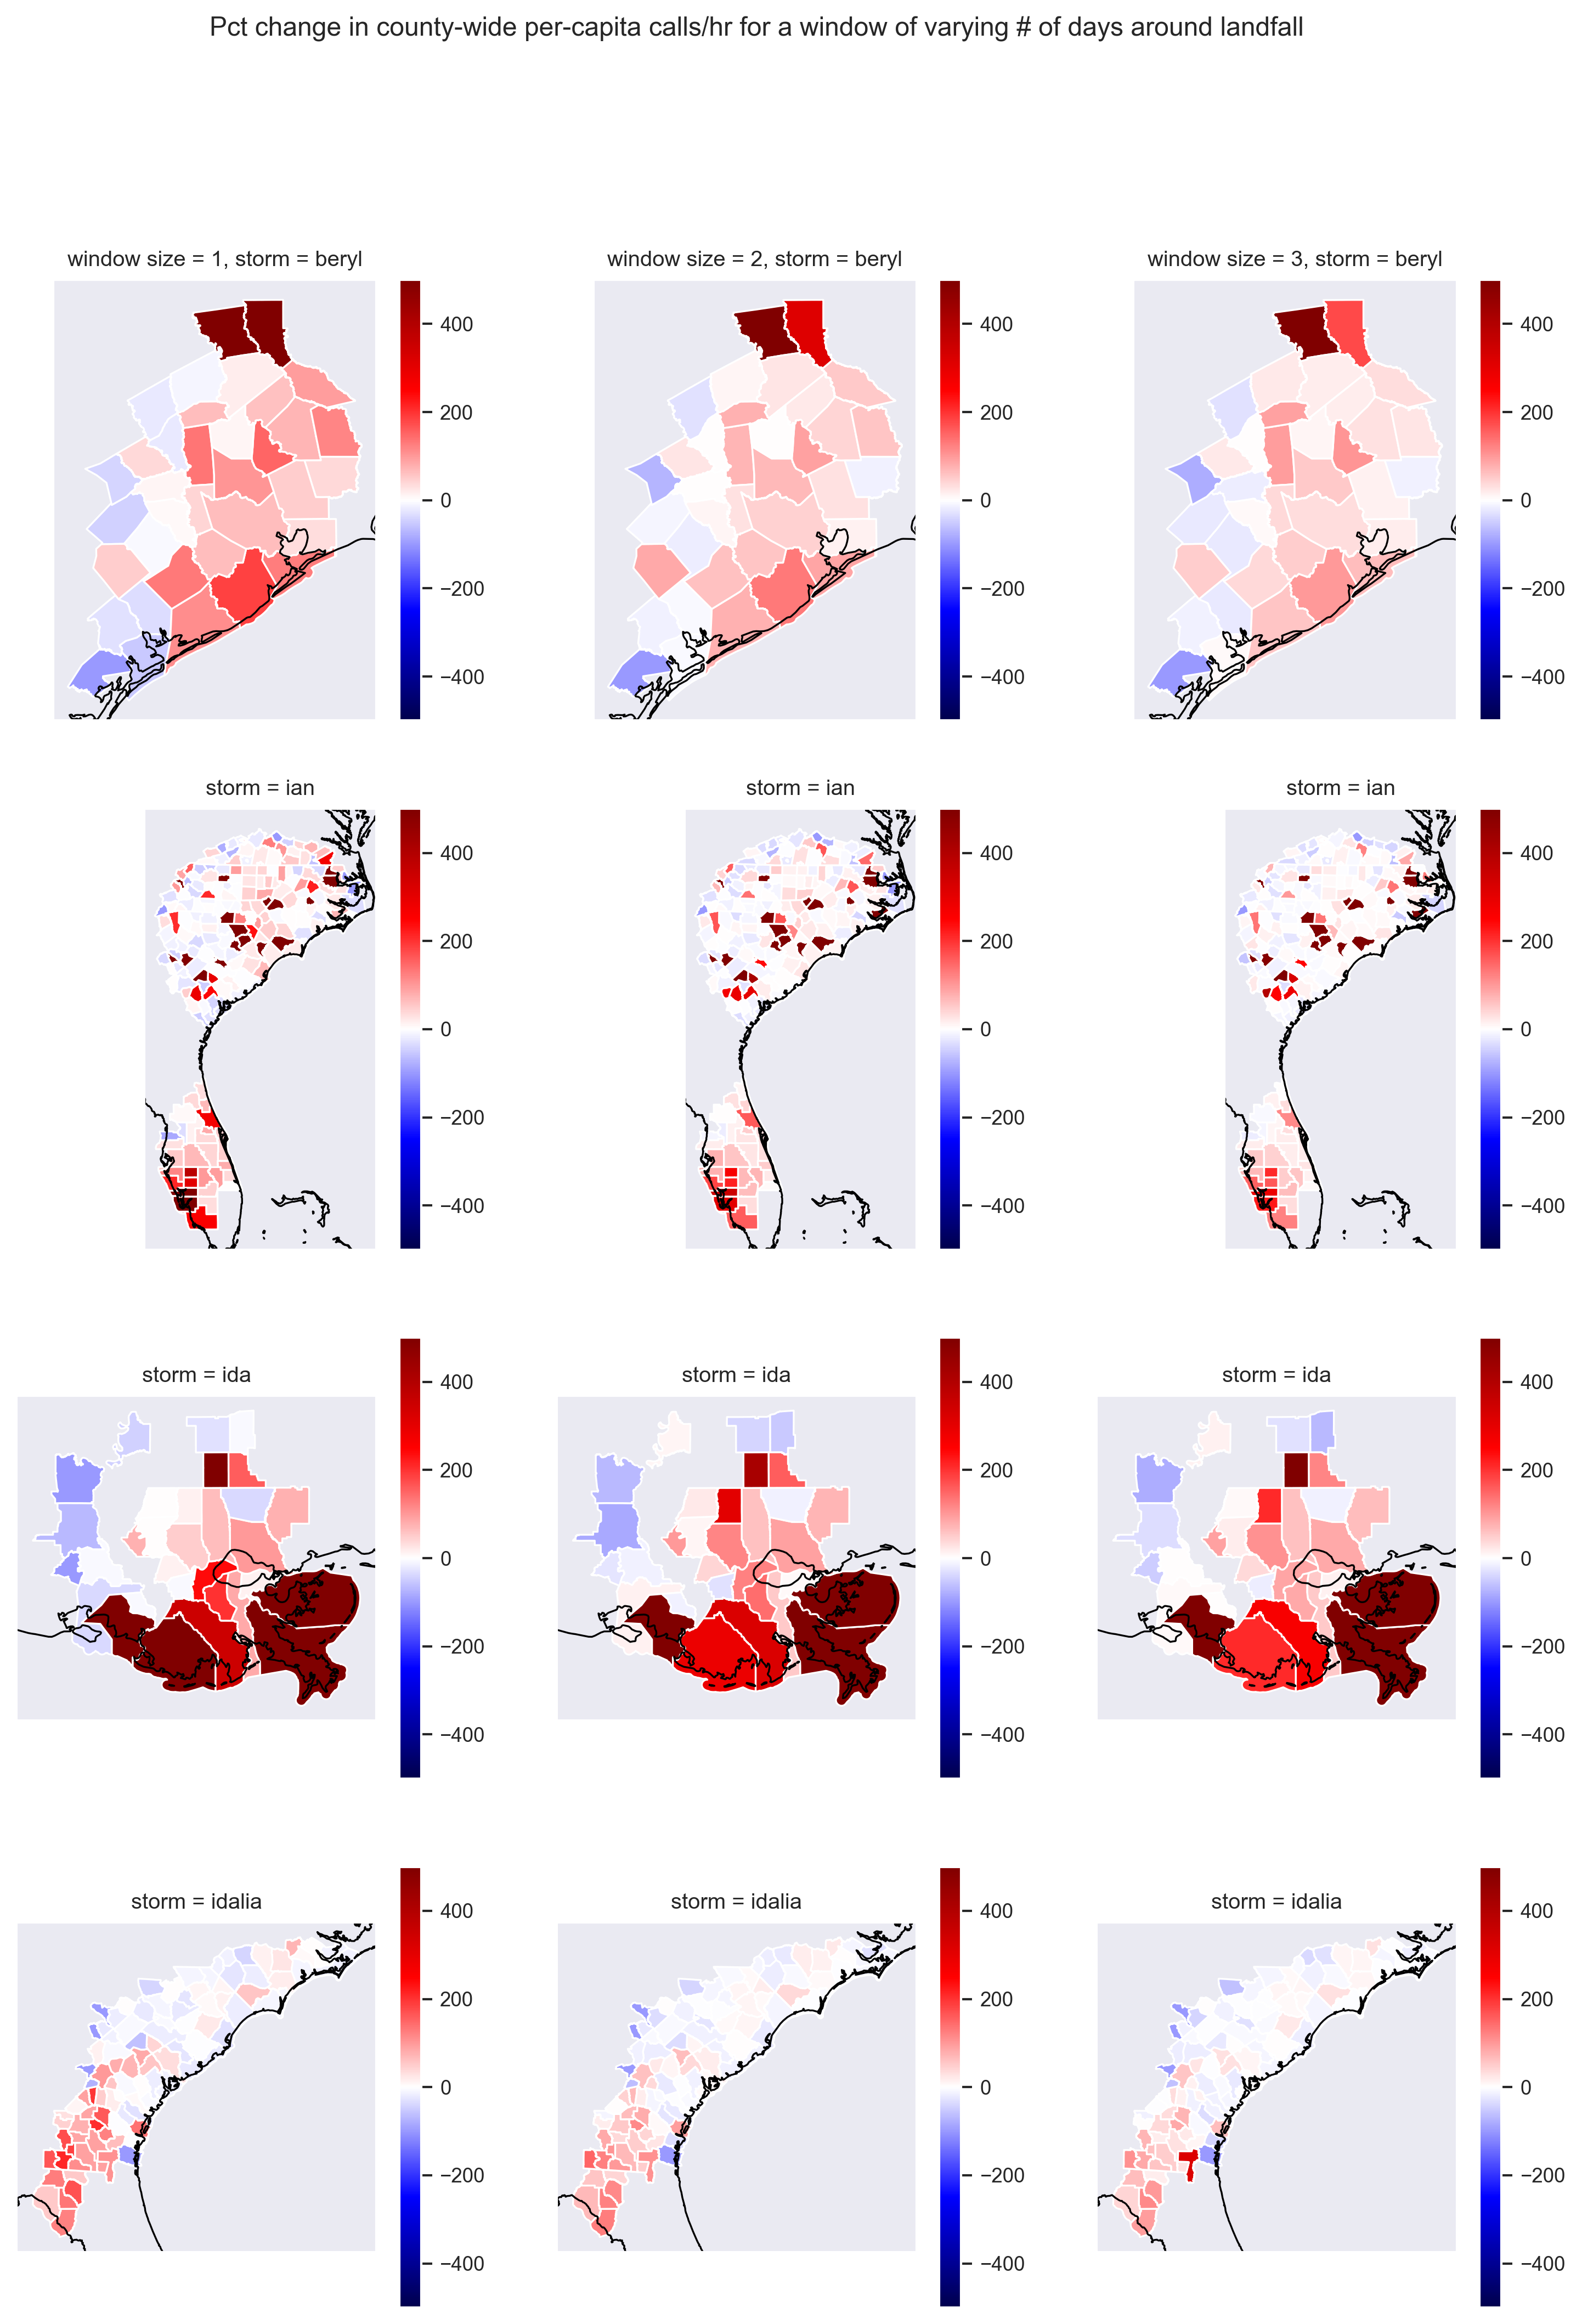

In [15]:
window_sizes = [1, 2, 3]
storms = no_wind_data.index.get_level_values("storm").unique()
fig, ax = plt.subplots(
    len(storms),
    len(window_sizes),
    figsize=(4 * len(window_sizes), 4 * len(storms)),
    subplot_kw={"projection": ccrs.PlateCarree()},
)
for wx, w in enumerate(window_sizes):
    diff = (
        no_wind_data.loc[idx[-24 * w : 24 * w - 1]].groupby(["storm", "GEOID"]).sum()
        / (24 * w * 2 + 1)
    ) - pre_calls
    diff = gpd.GeoDataFrame(
        diff.to_frame().join(counties.set_index("GEOID"), on="GEOID"),
        geometry="geometry",
        crs="EPSG:4326",
    )
    pct_change = diff.copy().assign(call_count=lambda x: 100 * x.call_count / pre_calls)
    pct_change["call_count"] = pct_change.call_count.where(
        ~np.isinf(pct_change.call_count)
    )
    for sx, s in enumerate(storms):
        this_ax = ax[sx, wx]
        pct_change.loc[s].plot(
            column="call_count",
            cmap="seismic",
            norm=colors.Normalize(-500, 500),
            legend=True,
            ax=this_ax,
        )
        if sx == 0:
            this_ax.set_title(f"window size = {w}, storm = {s}")
        else:
            this_ax.set_title(f"storm = {s}")
        this_ax.coastlines()
fig.suptitle(
    "Pct change in county-wide per-capita calls/hr for a window of varying # of days around landfall"
)
for kind in ["png", "pdf"]:
    fig.savefig(FIG_DIR / f"county-callrate-map.{kind}")

### Diagnosing max wind speed signal on calls

In [16]:
no_county_calls = calls.groupby(["storm", "hour", "maxs"]).sum()

baseline_calls = (
    no_county_calls.loc[pd.IndexSlice[:, :baseline_end]]
    .groupby(["storm", "maxs"])
    .sum()
    / n_baseline_hrs
)

no_county_pops = pops.groupby(["storm", "maxs"]).sum()
baseline_calls_pc = baseline_calls / no_county_pops

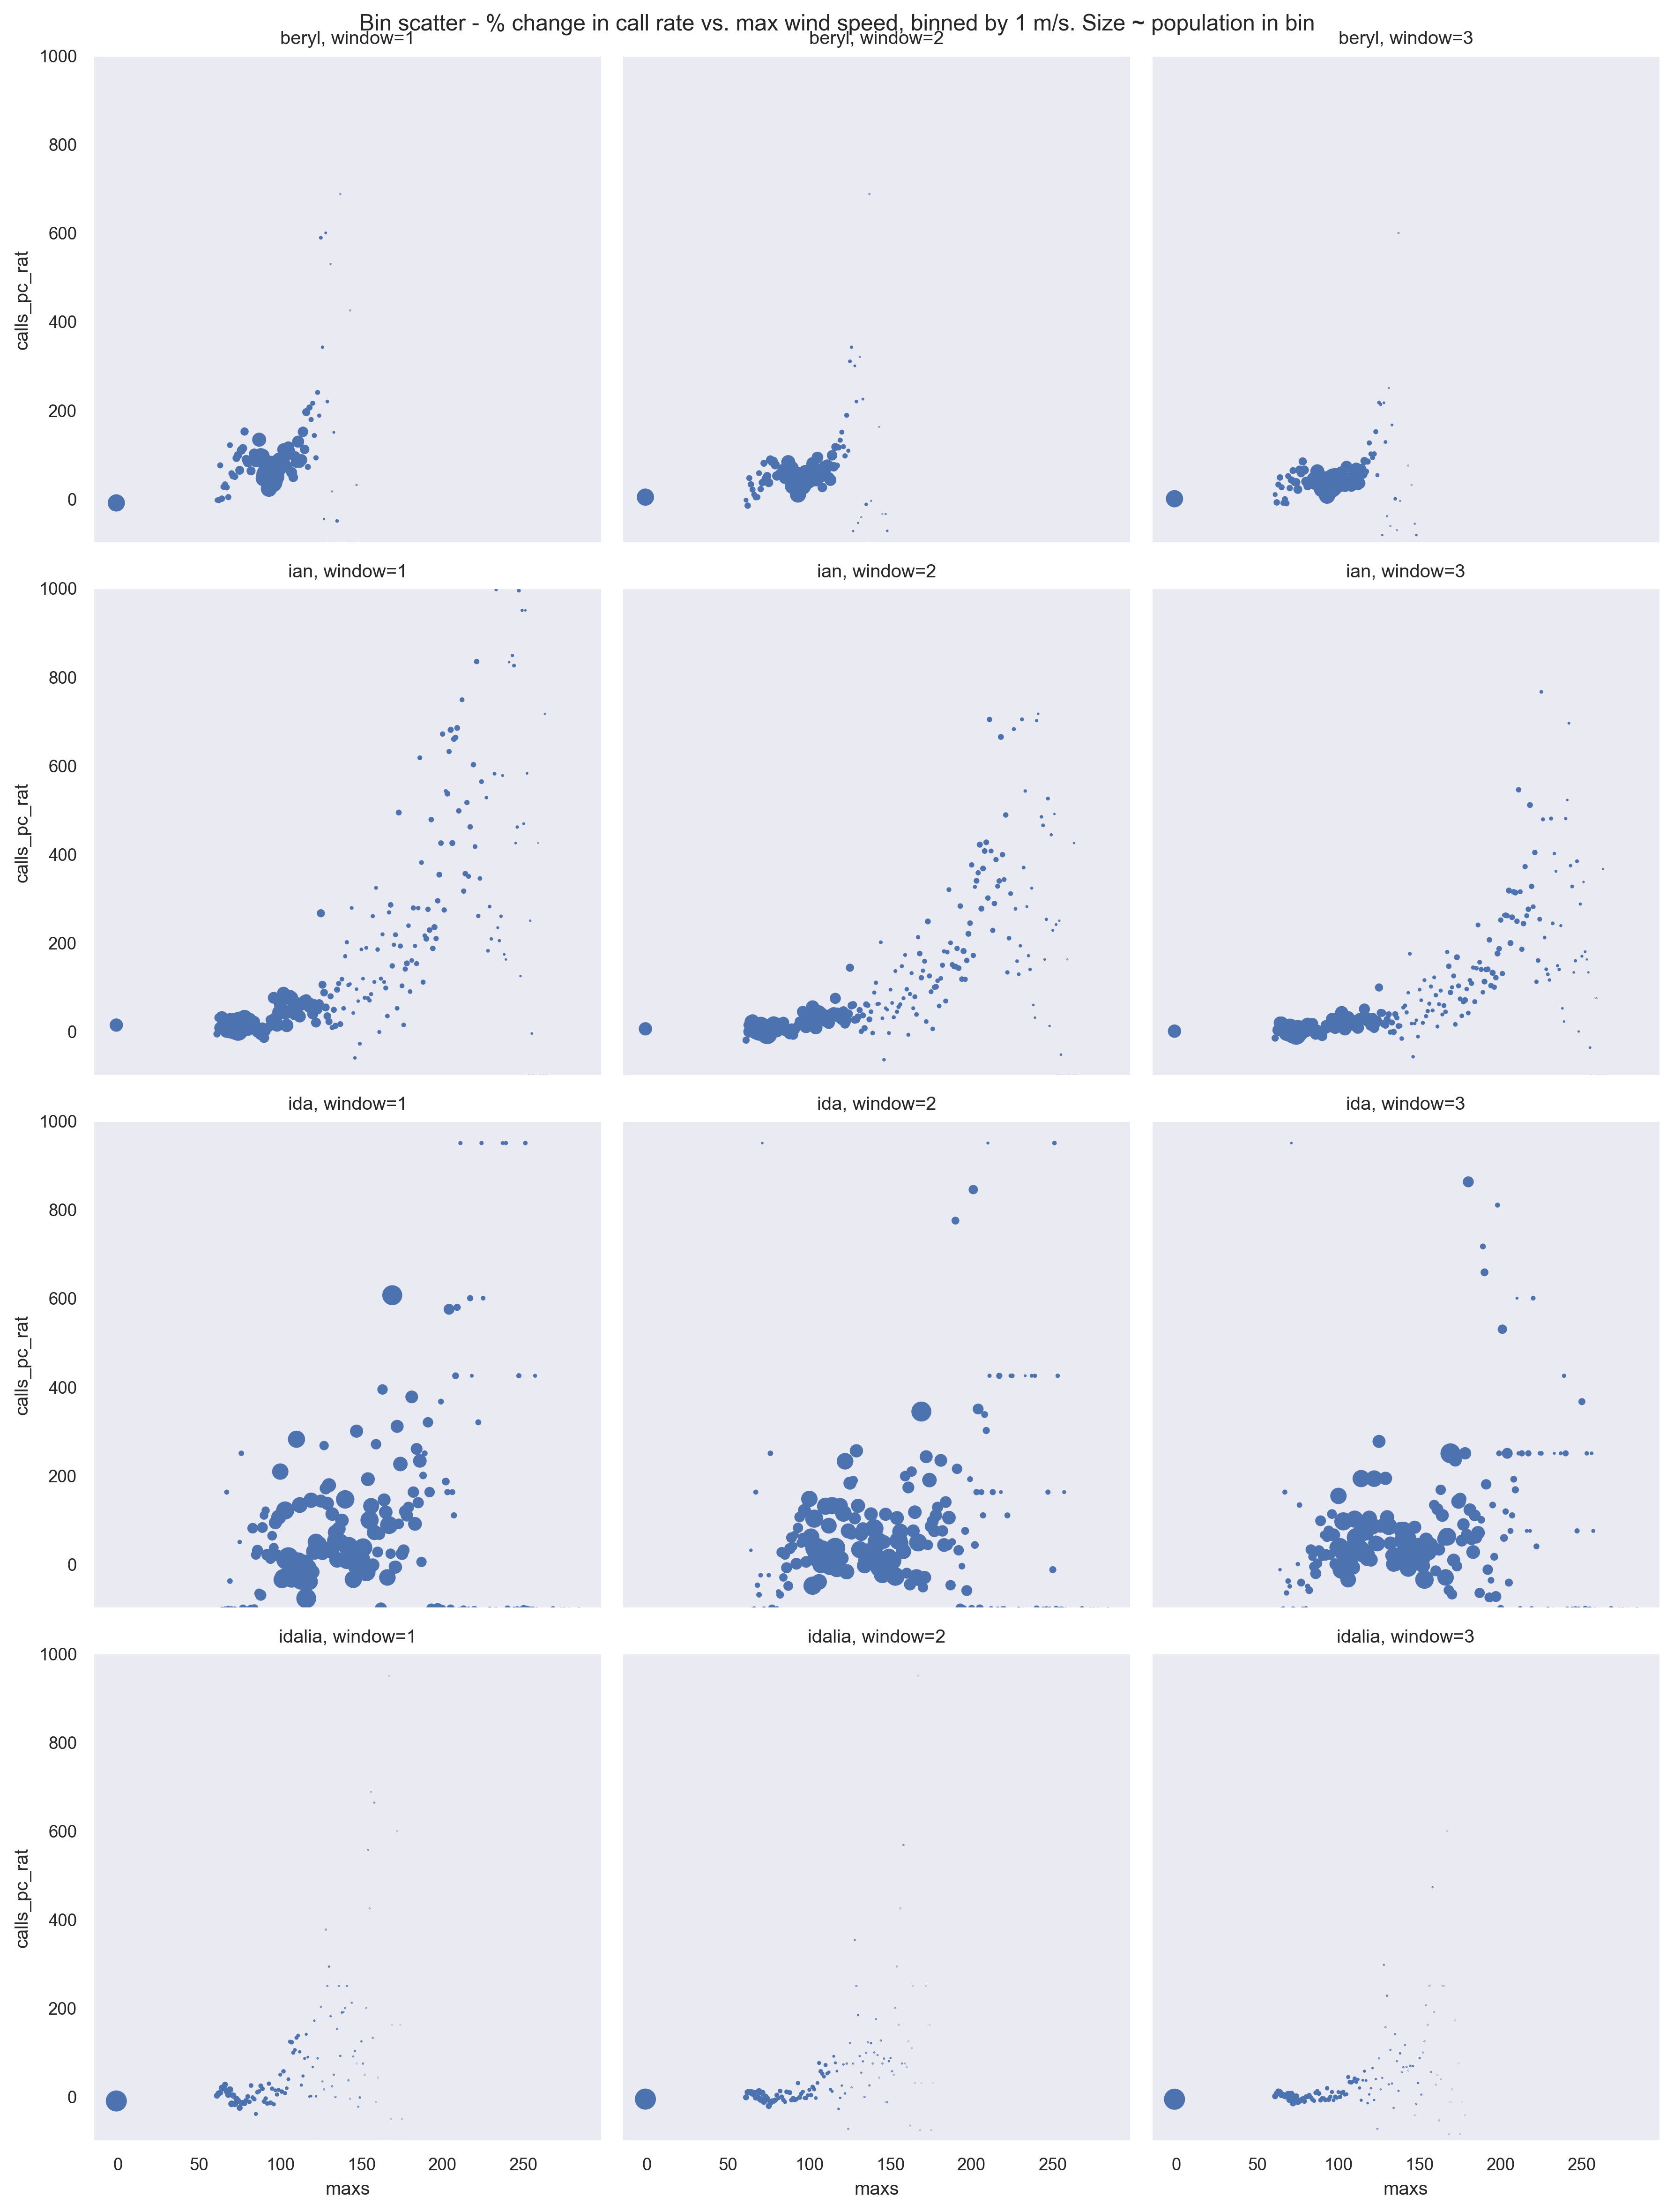

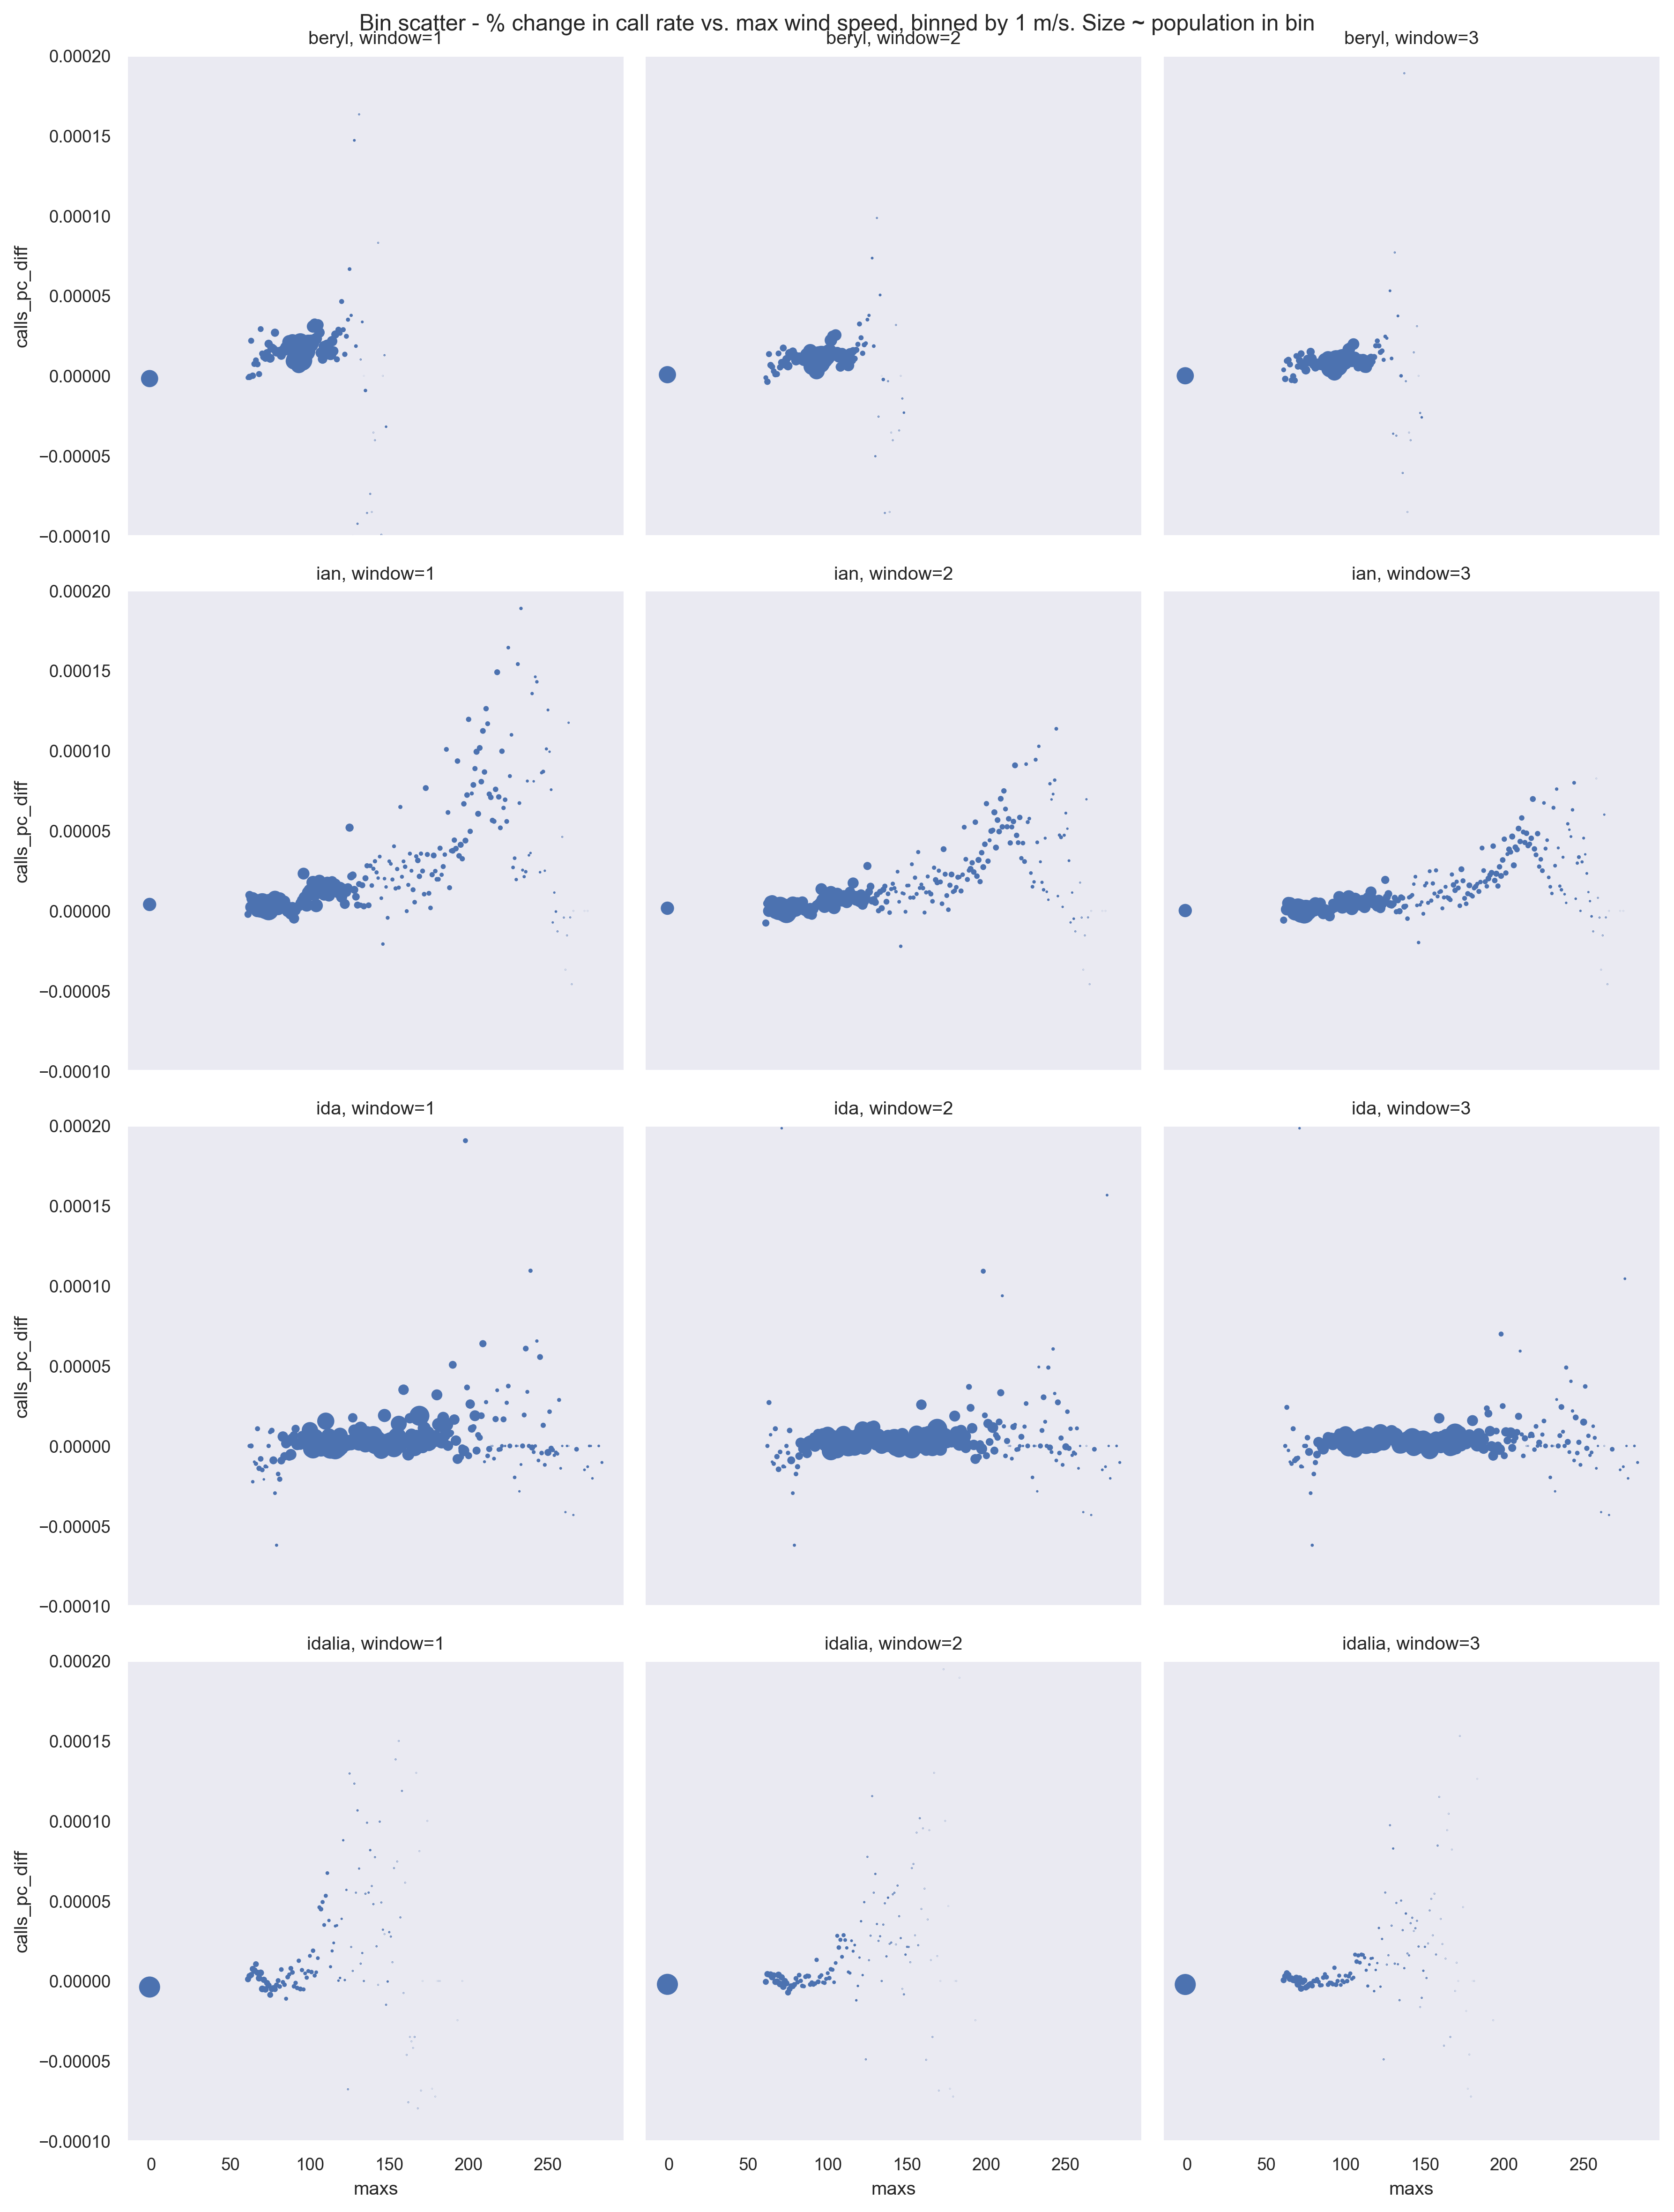

In [17]:
ylims = {"calls_pc_rat": (-100, 1000), "calls_pc_diff": (-0.0001, 0.0002)}
for var in ["calls_pc_rat", "calls_pc_diff"]:
    fig, ax = plt.subplots(
        len(storms),
        len(window_sizes),
        figsize=(4 * len(window_sizes), 4 * len(storms)),
        tight_layout=True,
        sharey=True,
        sharex=True,
    )
    for wx, w in enumerate(window_sizes):
        no_county_storm_period = (
            no_county_calls.loc[pd.IndexSlice[:, -w * 24 : w * 24 - 1]]
            .groupby(["storm", "maxs"])
            .sum()
            / (w * 24 * 2)
        ) / no_county_pops - baseline_calls_pc

        if var == "calls_pc_rat":
            no_county_storm_period = no_county_storm_period * 100 / baseline_calls_pc

        no_county_storm_period = no_county_storm_period.to_frame(var).join(
            no_county_pops.rename("population")
        )

        for sx, s in enumerate(storms):
            this_ax = ax[sx, wx]
            no_county_storm_period.loc[s].reset_index().assign(
                size=lambda x: x.population / x.population.max() * 100
            ).plot.scatter(x="maxs", y=var, ax=this_ax, s="size").set_ylim(*ylims[var])
            this_ax.set_title(f"{s}, window={w}")
    fig.suptitle(
        "Bin scatter - % change in call rate vs. max wind speed, binned by 1 m/s. Size ~ population in bin"
    )
    for kind in ["png", "pdf"]:
        fig.savefig(FIG_DIR / f"{var}-scatter.{kind}")

### Time series of call rates

In [18]:
# hour/day of week relative to closest landfall time (will be used to account for temporal oscillations)
hourly_calls = no_county_calls.copy()
daily_calls = (
    no_county_calls.groupby(
        ["storm", no_county_calls.index.get_level_values("hour") // 24, "maxs"]
    )
    .sum()
    .rename_axis(index={"hour": "day"})
)

how = hourly_calls.index.get_level_values("hour") % (24 * 7)
dow = daily_calls.index.get_level_values("day") % 7

baseline_calls_per_hr = (
    hourly_calls.to_frame()
    .assign(how=how)
    .loc[idx[:, :baseline_end], :]
    .groupby(["storm", "how", "maxs"])
    .call_count.sum()
    / N_BASELINE_WKS
)
baseline_calls_per_day = (
    daily_calls.to_frame()
    .assign(dow=dow)
    .loc[idx[:, :baseline_end_days], :]
    .groupby(["storm", "dow", "maxs"])
    .call_count.sum()
    / N_BASELINE_WKS
)

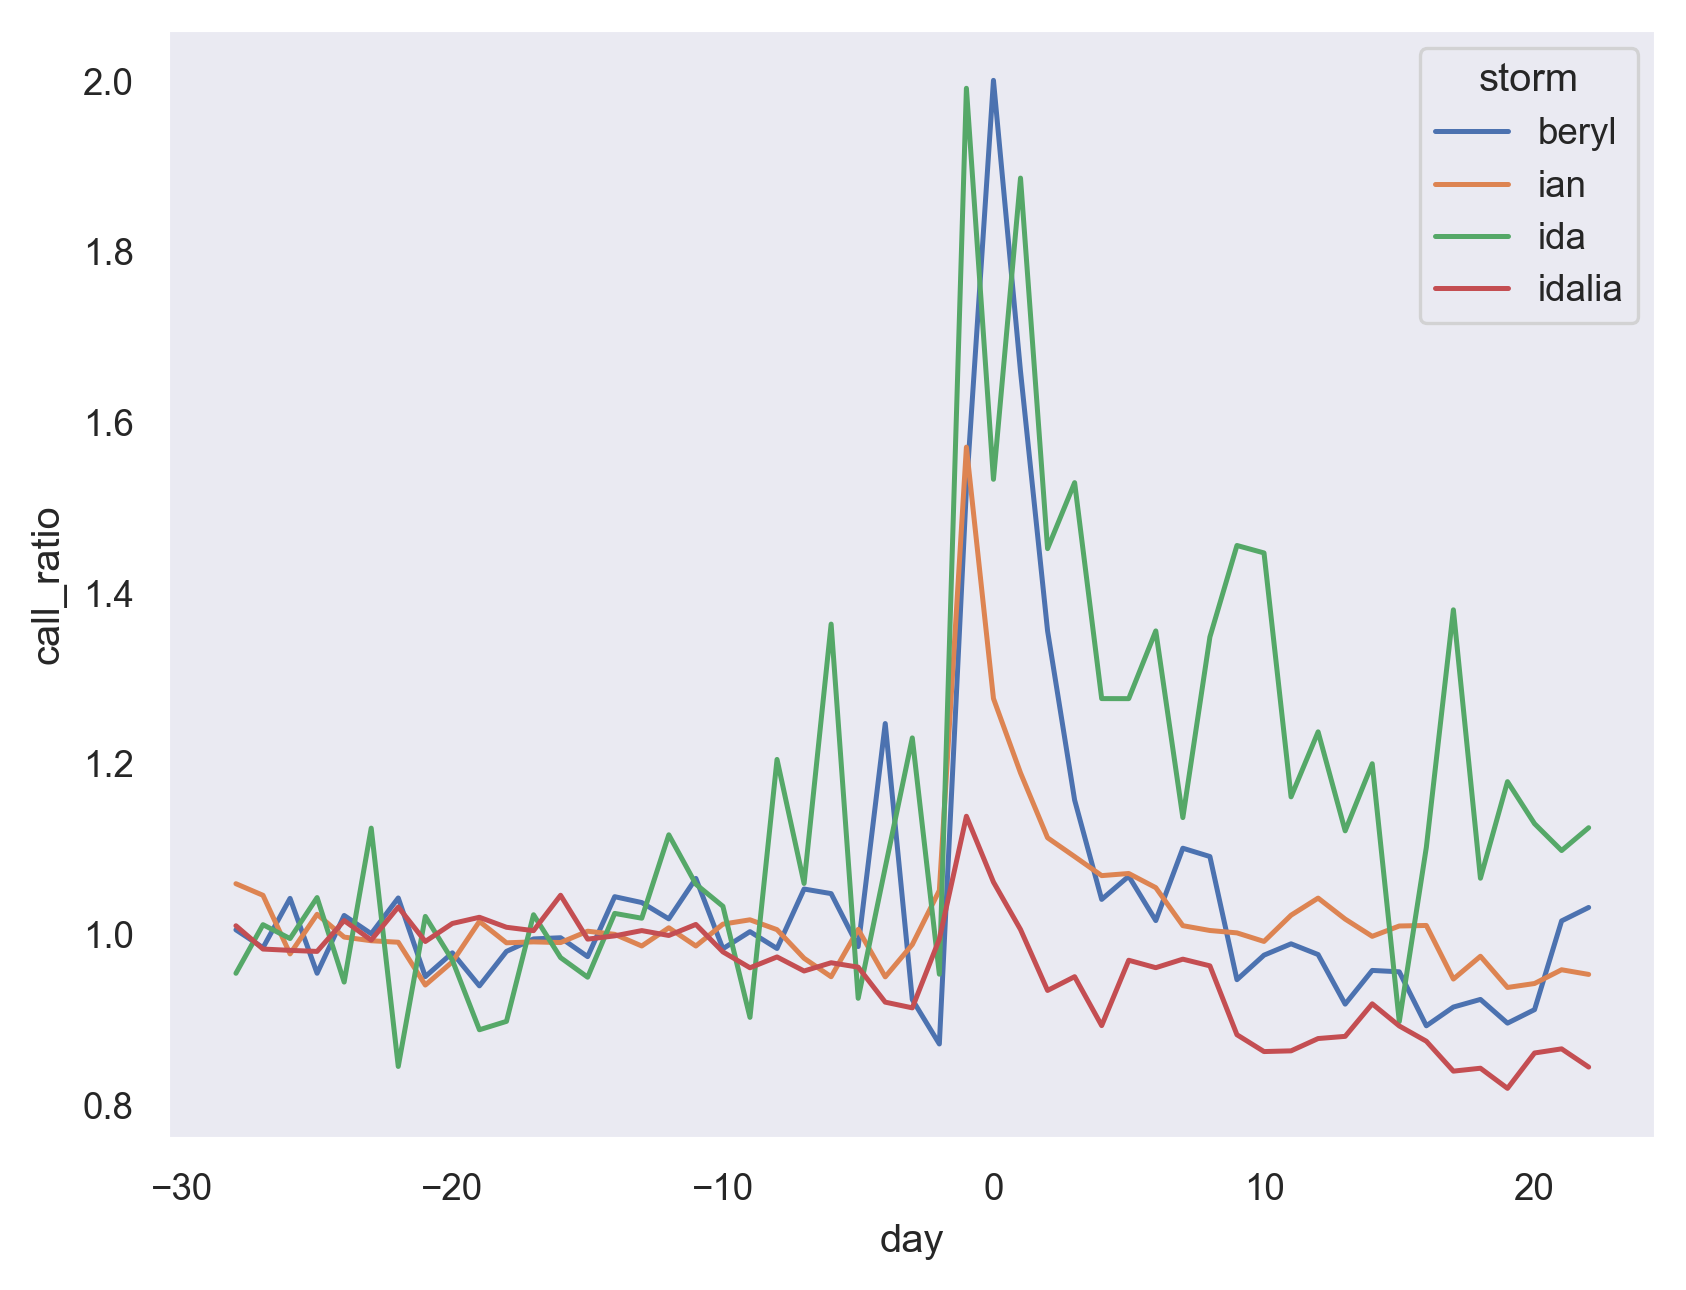

In [19]:
normalize_calls(
    daily_calls.groupby(["storm", "day"]).sum(),
    baseline_calls_per_day.groupby(["storm", "dow"]).sum(),
    how="ratio",
    fillinf=1 / N_BASELINE_WKS / 7,
).call_ratio.sort_index().to_xarray().plot(hue="storm")

## Regressions

### Reg 1: pct change from baseline in *daily* call rate as a function of wind speed
We start with a daily call rate regression, to minimize the degrees of freedom (vs. hourly). We collapse all hexagons experiencing the same wind speed and use a linear regression weighted by baseline call rate. Baselines are calculated for each day-of-week to account for non-hurricane-related trends (e.g. weekends having a different call volume). We have 3 weeks of baseline in the RapidSOS data, so note there are only 3 observations to form each day-of-week baseline value for each max wind speed group. More non-hurricane data would yield less noise in these baseline values.

#### Some assumptions
* Data Generating Process is a multiplicative effect on call rate, not additive
* All hexagons that receive the same wind speed have the same mean response

In [20]:
start_day = -14
end_day = 21

reg_df = normalize_calls(
    daily_calls, baseline_calls_per_day, how="ratio", fillinf=1 / N_BASELINE_WKS / 7
)
reg_df["call_ratio"] -= 1
reg_df = reg_df[reg_df.baseline > 0]

# time slice
reg_df = reg_df.loc[idx[:, start_day:end_day], :]

reg_df = reg_df.join(no_county_pops, on=["storm", "maxs"]).reset_index()
reg_df["wind_over_thresh"] = (reg_df.maxs - 61).clip(0, np.inf)
reg_df["has_wind"] = reg_df.maxs > 0

In [21]:
res = smf.wls(
    "call_ratio ~ np.power(wind_over_thresh, 2)*C(day) + C(day):has_wind",
    data=reg_df,
    weights=reg_df.baseline,
).fit()

# this is chosen spec for Milton test case, so we save it here
m_res = res

res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Weighted least squares
===========================================================================================
Model:                      WLS                      Adj. R-squared:             0.228     
Dependent Variable:         call_ratio               AIC:                        56638.7013
Date:                       2024-11-14 12:37         BIC:                        57487.1128
No. Observations:           19066                    Log-Likelihood:             -28211.   
Df Model:                   107                      F-statistic:                53.50     
Df Residuals:               18958                    Prob (F-statistic):         0.00      
R-squared:                  0.232                    Scale:                      7.5493    
-------------------------------------------------------------------------------------------
                                             Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------------------
Intercept                                    0.0080   0.0606  0.1312 0.8956 -0.1109  0.1268
C(day)[T.-13]                                0.0055   0.0843  0.0657 0.9477 -0.1597  0.1708
C(day)[T.-12]                                0.0017   0.0836  0.0202 0.9839 -0.1621  0.1655
C(day)[T.-11]                                0.0221   0.0857  0.2575 0.7968 -0.1460  0.1902
C(day)[T.-10]                               -0.0243   0.0846 -0.2867 0.7743 -0.1901  0.1416
C(day)[T.-9]                                -0.0267   0.0853 -0.3132 0.7541 -0.1940  0.1405
C(day)[T.-8]                                 0.0040   0.0860  0.0470 0.9625 -0.1645  0.1726
C(day)[T.-7]                                -0.0234   0.0857 -0.2726 0.7852 -0.1914  0.1447
C(day)[T.-6]                                -0.0158   0.0843 -0.1878 0.8510 -0.1811  0.1494
C(day)[T.-5]                                -0.0597   0.0836 -0.7139 0.4753 -0.2235  0.1041
C(day)[T.-4]                                -0.0062   0.0857 -0.0719 0.9427 -0.1742  0.1619
C(day)[T.-3]                                -0.0930   0.0846 -1.0995 0.2716 -0.2589  0.0728
C(day)[T.-2]                                -0.0076   0.0853 -0.0895 0.9287 -0.1749  0.1596
C(day)[T.-1]                                -0.0462   0.0860 -0.5376 0.5909 -0.2148  0.1223
C(day)[T.0]                                 -0.0399   0.0857 -0.4657 0.6415 -0.2080  0.1281
C(day)[T.1]                                 -0.0290   0.0843 -0.3442 0.7307 -0.1943  0.1362
C(day)[T.2]                                 -0.1315   0.0836 -1.5739 0.1155 -0.2953  0.0323
C(day)[T.3]                                 -0.0476   0.0857 -0.5547 0.5791 -0.2156  0.1205
C(day)[T.4]                                 -0.1355   0.0846 -1.6014 0.1093 -0.3014  0.0304
C(day)[T.5]                                 -0.0334   0.0853 -0.3916 0.6954 -0.2006  0.1338
C(day)[T.6]                                 -0.0517   0.0860 -0.6006 0.5481 -0.2202  0.1169
C(day)[T.7]                                  0.0117   0.0857  0.1363 0.8916 -0.1564  0.1798
C(day)[T.8]                                 -0.0790   0.0843 -0.9374 0.3486 -0.2443  0.0862
C(day)[T.9]                                 -0.0811   0.0836 -0.9708 0.3316 -0.2449  0.0827
C(day)[T.10]                                -0.1172   0.0857 -1.3669 0.1717 -0.2853  0.0509
C(day)[T.11]                                -0.1498   0.0846 -1.7705 0.0767 -0.3157  0.0160
C(day)[T.12]                                -0.0969   0.0853 -1.1356 0.2562 -0.2641  0.0703
C(day)[T.13]                                -0.0448   0.0860 -0.5204 0.6028 -0.2133  0.1238
C(day)[T.14]                                -0.0696   0.0857 -0.8121 0.4168 -0.2377  0.0984
C(day)[T.15]                                -0.1195   0.0843 -1.4174 0.1564 -0.2848  0.0458
C(day)[T.16]                                -0.1534   0.0836 -1.8360 0.0664 -0.3172  0.0104
C(day)[T.17]             

<Axes: xlabel='Days Since Landfall', ylabel='Fractional marginal change in call rate per $(\\frac{km}{h})^2$'>

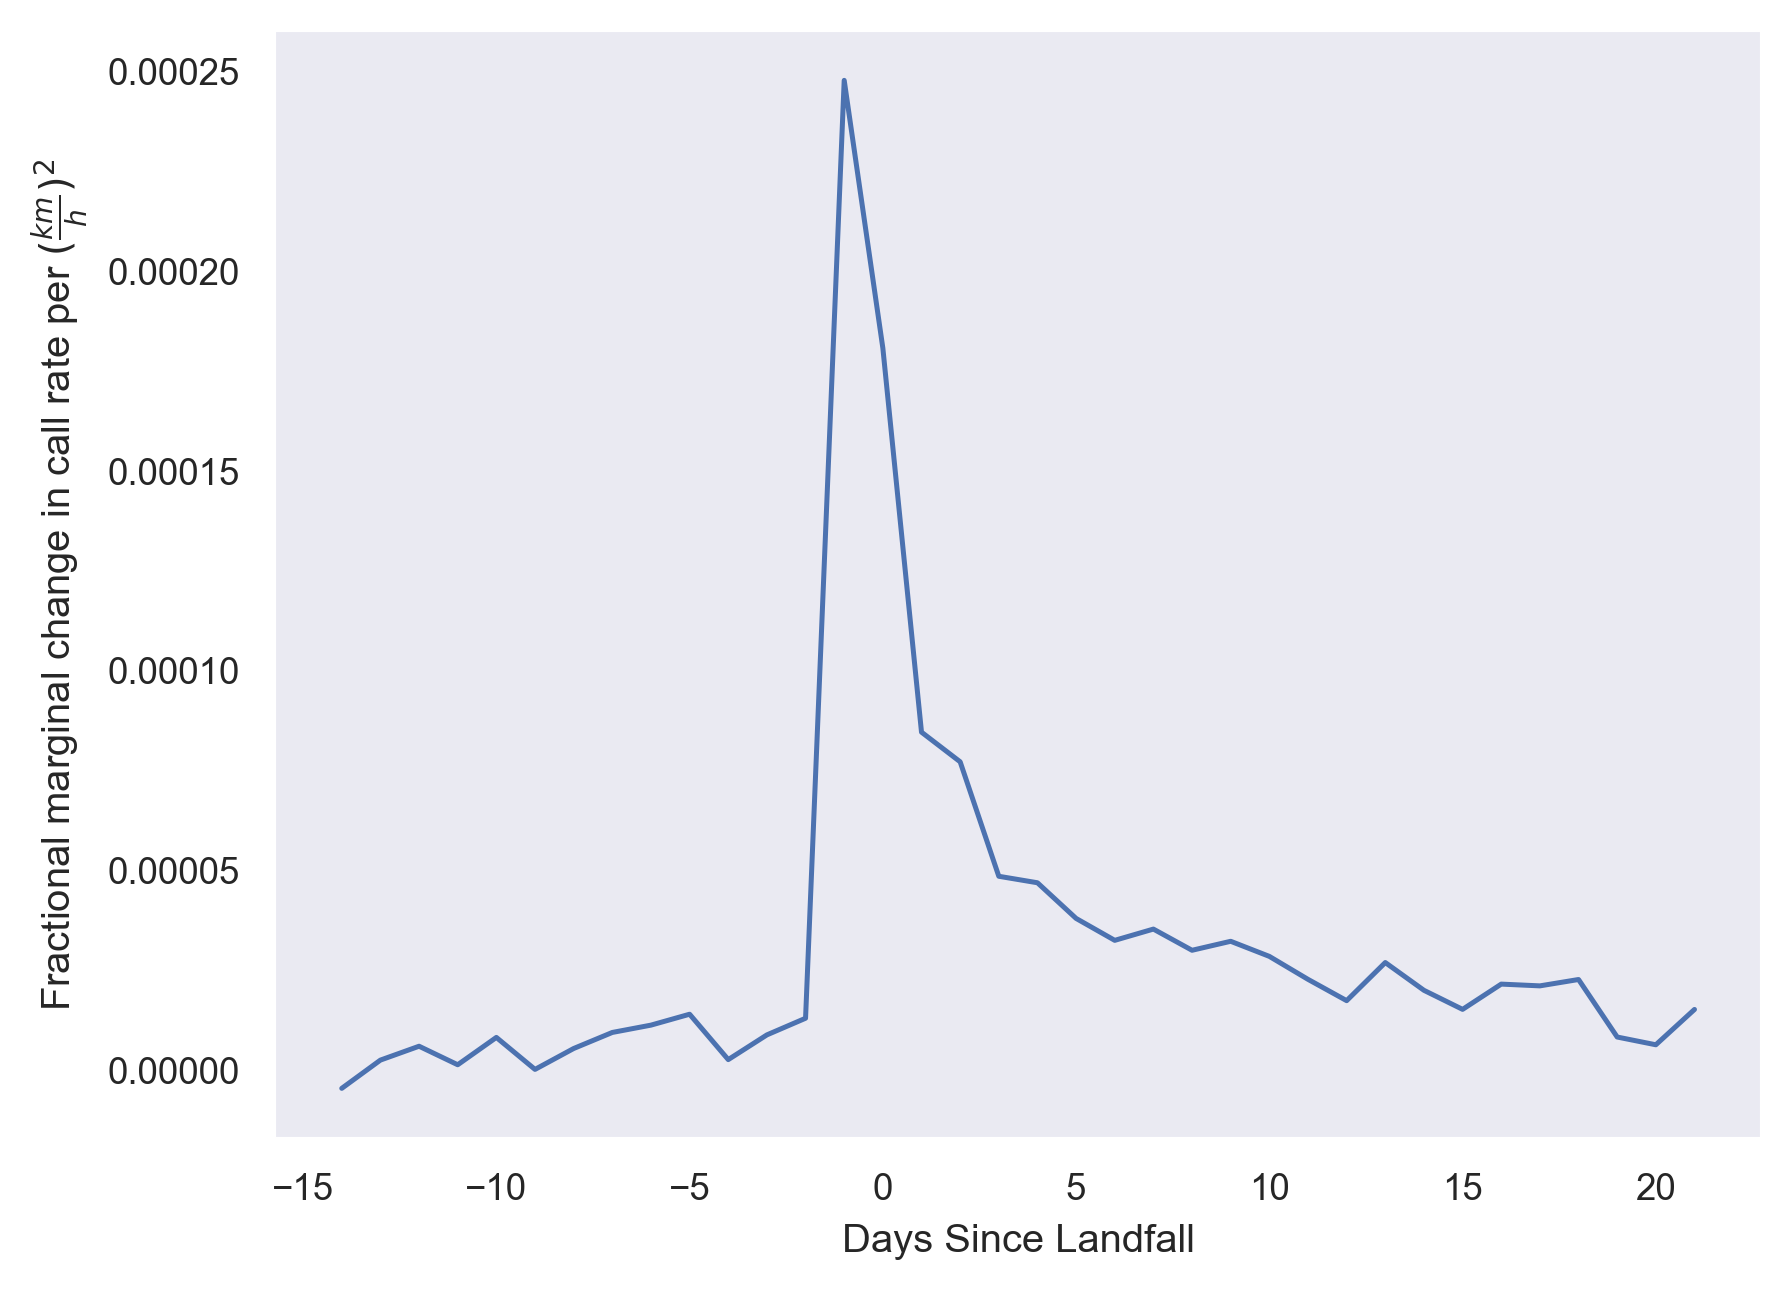

In [22]:
coefs = res.params.filter(like="wind_over_thresh")
coefs.index = np.arange(start_day, end_day + 1)

coefs.plot(
    xlabel="Days Since Landfall",
    ylabel=r"Fractional marginal change in call rate per $(\frac{km}{h})^2$",
)

### Reg 2: pct change from baseline in *hourly* call rate as a function of wind speed
Now we try capturing the sharper, sub-daily, response using hourly call rate instead of daily. To account for both diurnal and day-of-week trends, baselines are calculated for each of the 24*7=168 hours per week. B/c we use the 3-week baseline, and b/c hourly call rates are more noisy than daily call rates, this means the baseline can be fairly noisy (moreso than with daily rates).

Other key assumptions are generally the same as in Reg 1.

In [23]:
start_hour = -7 * 24
end_hour = 7 * 24

reg_df = normalize_calls(
    hourly_calls,
    baseline_calls_per_hr,
    how="ratio",
    fillinf=1 / N_BASELINE_WKS / 7 / 24,
)
reg_df["call_ratio"] -= 1
reg_df = reg_df[reg_df.baseline > 0]

# time slice
reg_df = reg_df.loc[idx[:, start_hour:end_hour], :]

reg_df = reg_df.join(no_county_pops, on=["storm", "maxs"]).reset_index()
reg_df["wind_over_thresh"] = (reg_df.maxs - 61).clip(0, np.inf)
reg_df["has_wind"] = reg_df.maxs > 0

In [24]:
res = smf.wls(
    "call_ratio ~ np.power(wind_over_thresh, 2)*C(hour) + C(hour):has_wind",
    data=reg_df,
    weights=reg_df.baseline,
).fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Weighted least squares
============================================================================================
Model:                      WLS                      Adj. R-squared:             -0.007     
Dependent Variable:         call_ratio               AIC:                        830722.8340
Date:                       2024-11-14 12:37         BIC:                        840321.1417
No. Observations:           98113                    Log-Likelihood:             -4.1435e+05
Df Model:                   1010                     F-statistic:                0.3360     
Df Residuals:               97102                    Prob (F-statistic):         1.00       
R-squared:                  0.003                    Scale:                      241.24     
--------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                      0.2453   2.1335  0.1150 0.9085 -3.9363 4.4268
C(hour)[T.-167]                                0.0308   3.1548  0.0098 0.9922 -6.1525 6.2141
C(hour)[T.-166]                               -0.4711   3.0366 -0.1551 0.8767 -6.4227 5.4806
C(hour)[T.-165]                               -0.2606   3.1743 -0.0821 0.9346 -6.4822 5.9611
C(hour)[T.-164]                               -0.3677   3.0781 -0.1195 0.9049 -6.4008 5.6654
C(hour)[T.-163]                               -0.2018   3.0078 -0.0671 0.9465 -6.0970 5.6934
C(hour)[T.-162]                               -0.3153   2.8584 -0.1103 0.9122 -5.9176 5.2871
C(hour)[T.-161]                               -0.5216   2.7795 -0.1877 0.8511 -5.9695 4.9263
C(hour)[T.-160]                               -0.2927   2.6820 -0.1091 0.9131 -5.5494 4.9639
C(hour)[T.-159]                               -0.4580   2.6680 -0.1717 0.8637 -5.6872 4.7711
C(hour)[T.-158]                               -0.4979   2.6563 -0.1874 0.8513 -5.7042 4.7084
C(hour)[T.-157]                               -0.3410   2.6680 -0.1278 0.8983 -5.5702 4.8882
C(hour)[T.-156]                               -0.3243   2.5983 -0.1248 0.9007 -5.4170 4.7684
C(hour)[T.-155]                               -0.2617   2.6314 -0.0994 0.9208 -5.4193 4.8959
C(hour)[T.-154]                               -0.1414   2.5883 -0.0546 0.9564 -5.2144 4.9316
C(hour)[T.-153]                               -0.2693   2.5459 -0.1058 0.9158 -5.2592 4.7206
C(hour)[T.-152]                               -0.2050   2.5489 -0.0804 0.9359 -5.2009 4.7909
C(hour)[T.-151]                               -0.3619   2.5616 -0.1413 0.8876 -5.3827 4.6588
C(hour)[T.-150]                               -0.2088   2.5660 -0.0814 0.9352 -5.2382 4.8206
C(hour)[T.-149]                               -0.0876   2.6420 -0.0331 0.9736 -5.2659 5.0908
C(hour)[T.-148]                                0.1833   2.6483  0.0692 0.9448 -5.0073 5.3738
C(hour)[T.-147]                               -0.3912   2.6697 -0.1465 0.8835 -5.6237 4.8413
C(hour)[T.-146]                               -0.2881   2.8281 -0.1019 0.9188 -5.8311 5.2548
C(hour)[T.-145]                               -0.1314   2.8521 -0.0461 0.9632 -5.7215 5.4586
C(hour)[T.-144]                               -0.1812   2.7649 -0.0655 0.9478 -5.6003 5.2379
C(hour)[T.-143]                                0.0547   3.0621  0.0179 0.9857 -5.9470 6.0564
C(hour)[T.-142]                               -0.4021   3.0466 -0.1320 0.8950 -6.3735 5.5692
C(hour)[T.-141]                               -0.3314   3.0569 -0.1084 0.9137 -6.3228 5.6601
C(hour)[T.-140]                               -0.4026   2.9356 -0.1371 0.8909 -6.1562 5.3511
C(hour)[T.-139]                               -0.1795   3.0517 -0.0588 0.9531 -6.1608 5.8018
C(hour)[T.-138]                               -0.4371   2.7396 -0.1596 0.873

<Axes: >

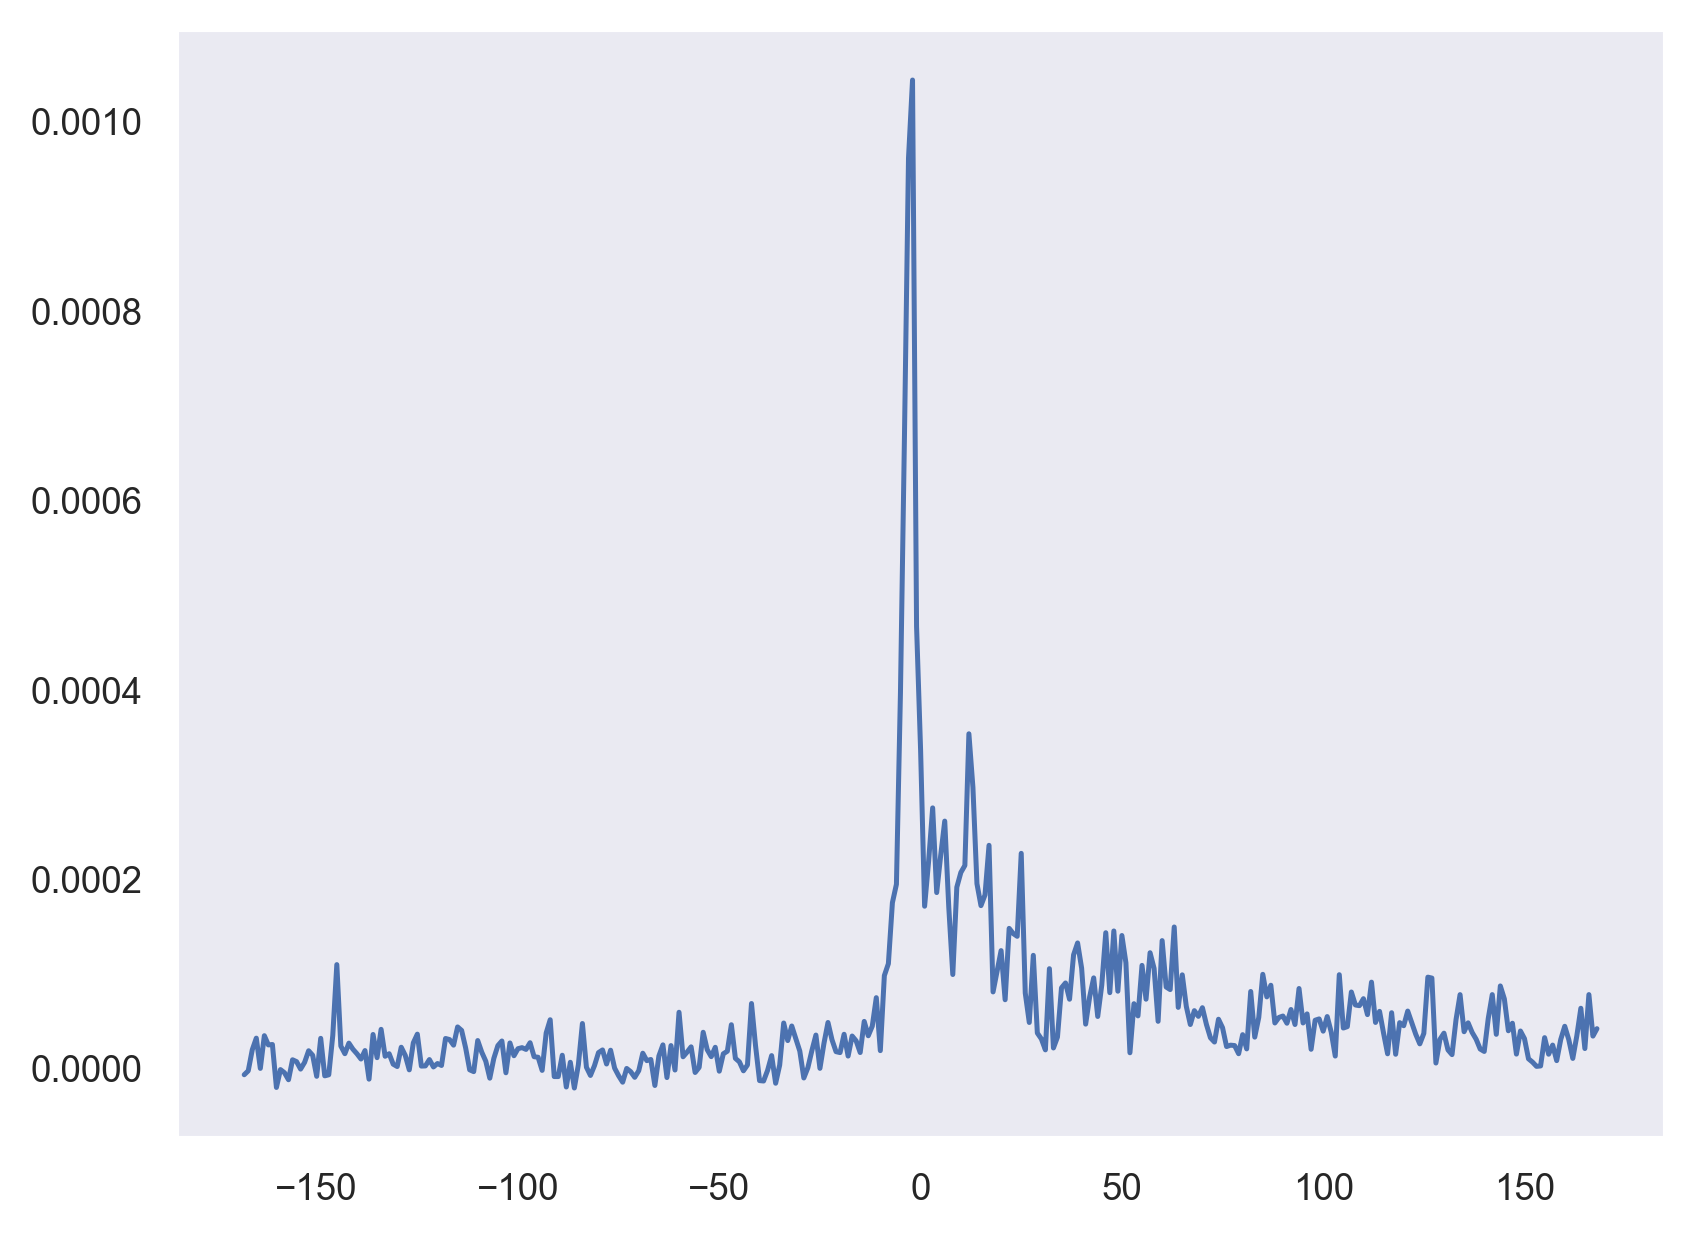

In [25]:
coefs = res.params.filter(like="wind_over_thresh")
coefs.index = np.arange(start_hour, end_hour + 1)
coefs.plot()

This is clearly noisier than the daily regression but does allow for capturing the sub-daily, sharper response.

### Reg 3: Difference from baseline in *daily* call rate as a function of wind speed

Same as Reg 1 but using CRD instead of CRR. Assumes that the DGP is one in which hurricane winds create new emergency response calls in an additive, rather than multiplicative, way.

In [26]:
start_day = -7
end_day = 21

reg_df = normalize_calls(daily_calls, baseline_calls_per_day, how="diff")

# time slice
reg_df = reg_df.loc[idx[:, start_day:end_day], :]

reg_df = reg_df.join(no_county_pops, on=["storm", "maxs"]).reset_index()
reg_df["wind_over_thresh"] = (reg_df.maxs - 61).clip(0, np.inf)
reg_df["has_wind"] = reg_df.maxs > 0

res = smf.wls(
    "call_diff ~ np.power(wind_over_thresh, 2)*C(day) + C(day):has_wind",
    data=reg_df,
    weights=reg_df.population,
).fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Weighted least squares
==========================================================================================
Model:                     WLS                     Adj. R-squared:            0.254       
Dependent Variable:        call_diff               AIC:                       -224317.0171
Date:                      2024-11-14 12:37        BIC:                       -223636.7341
No. Observations:          18386                   Log-Likelihood:            1.1225e+05  
Df Model:                  86                      F-statistic:               73.70       
Df Residuals:              18299                   Prob (F-statistic):        0.00        
R-squared:                 0.257                   Scale:                     0.0024610   
------------------------------------------------------------------------------------------
                                            Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------------------------------
Intercept                                  -0.0000   0.0000 -0.4075 0.6837 -0.0001  0.0000
C(day)[T.-6]                                0.0000   0.0000  0.1304 0.8962 -0.0001  0.0001
C(day)[T.-5]                               -0.0000   0.0000 -0.7855 0.4322 -0.0001  0.0001
C(day)[T.-4]                                0.0000   0.0000  0.3215 0.7478 -0.0001  0.0001
C(day)[T.-3]                               -0.0001   0.0000 -1.3891 0.1648 -0.0001  0.0000
C(day)[T.-2]                                0.0000   0.0000  0.2942 0.7686 -0.0001  0.0001
C(day)[T.-1]                               -0.0000   0.0000 -0.4185 0.6756 -0.0001  0.0001
C(day)[T.0]                                -0.0000   0.0000 -0.3094 0.7571 -0.0001  0.0001
C(day)[T.1]                                -0.0000   0.0000 -0.1334 0.8938 -0.0001  0.0001
C(day)[T.2]                                -0.0001   0.0000 -2.2777 0.0228 -0.0002 -0.0000
C(day)[T.3]                                -0.0000   0.0000 -0.4519 0.6513 -0.0001  0.0001
C(day)[T.4]                                -0.0001   0.0000 -2.2262 0.0260 -0.0002 -0.0000
C(day)[T.5]                                -0.0000   0.0000 -0.1971 0.8437 -0.0001  0.0001
C(day)[T.6]                                -0.0000   0.0000 -0.5186 0.6040 -0.0001  0.0001
C(day)[T.7]                                 0.0000   0.0000  0.6551 0.5124 -0.0001  0.0001
C(day)[T.8]                                -0.0001   0.0000 -1.1343 0.2567 -0.0001  0.0000
C(day)[T.9]                                -0.0001   0.0000 -1.2314 0.2182 -0.0001  0.0000
C(day)[T.10]                               -0.0001   0.0000 -1.7530 0.0796 -0.0002  0.0000
C(day)[T.11]                               -0.0001   0.0000 -2.5082 0.0121 -0.0002 -0.0000
C(day)[T.12]                               -0.0001   0.0000 -1.4073 0.1594 -0.0002  0.0000
C(day)[T.13]                               -0.0000   0.0000 -0.3912 0.6956 -0.0001  0.0001
C(day)[T.14]                               -0.0000   0.0000 -0.8644 0.3874 -0.0001  0.0000
C(day)[T.15]                               -0.0001   0.0000 -1.9441 0.0519 -0.0002  0.0000
C(day)[T.16]                               -0.0001   0.0000 -2.7327 0.0063 -0.0002 -0.0000
C(day)[T.17]                               -0.0001   0.0000 -1.7166 0.0861 -0.0002  0.0000
C(day)[T.18]                               -0.0001   0.0000 -2.0624 0.0392 -0.0002 -0.0000
C(day)[T.19]                               -0.0001   0.0000 -2.8995 0.0037 -0.0002 -0.0000
C(day)[T.20]                               -0.0000   0.0000 -0.8007 0.4233 -0.0001  0.0001
C(day)[T.21]                               -0.0001   0.0000 -1.7561 0.0791 -0.0002  0.0000
C(day)[-7]:has_wind[T.True]                -0.0000   0.0000 -0.0334 0.9734 -0.0001  0.0001
C(day)[-6]:has_wind[T.True]                -0.0000   0.0000 -0.4163 0.6772 -0.0001  0.0001
C(day)[-5]:has_wind[T.True]                 0.0000   0.0000  1.1214 

<Axes: >

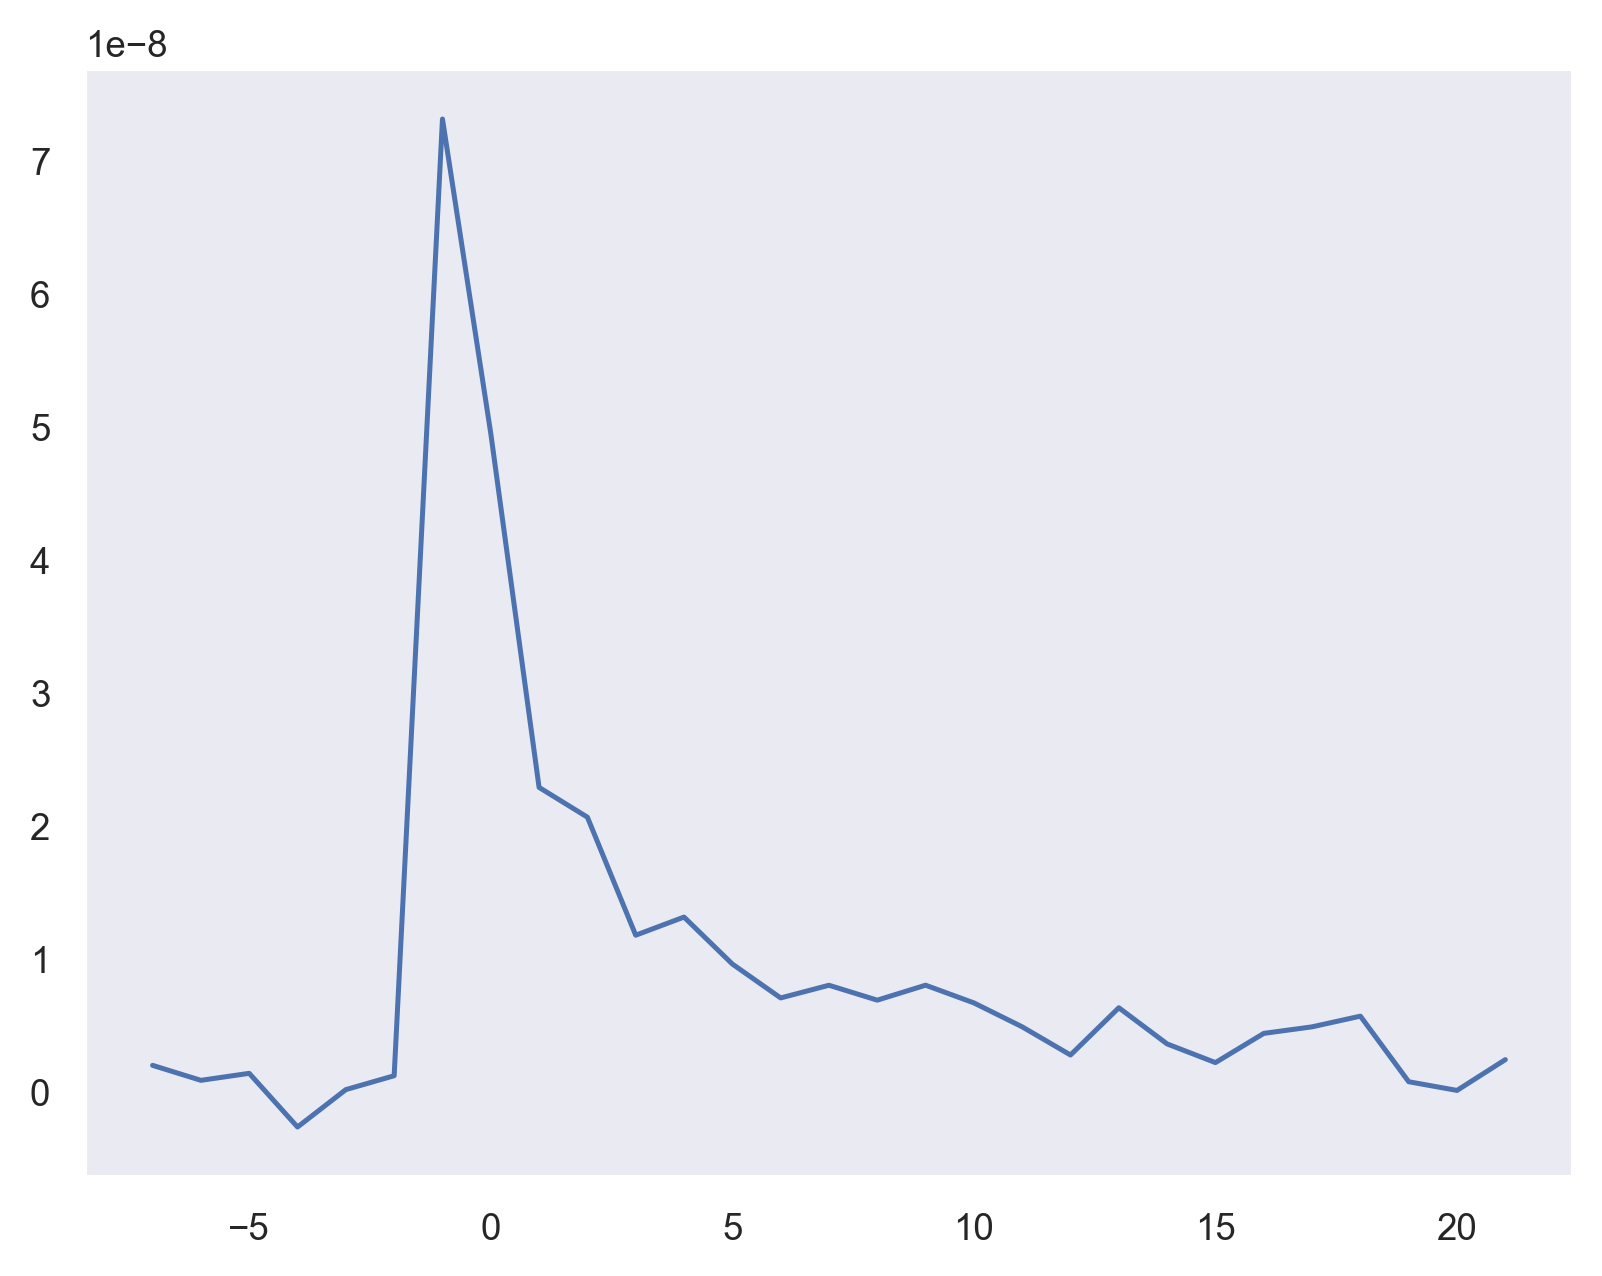

In [27]:
coefs = res.params.filter(like="wind_over_thresh")
coefs.index = np.arange(start_day, end_day + 1)

coefs.plot()

### Reg 4: Difference from baseline in *hourly* call rate as a function of wind speed
Same as Reg 3 but using hourly instead of daily call rate

In [28]:
start_hour = -7 * 24
end_hour = 7 * 24

reg_df = normalize_calls(hourly_calls, baseline_calls_per_hr, how="diff")

# time slice
reg_df = reg_df.loc[idx[:, start_hour:end_hour], :]

reg_df = reg_df.join(no_county_pops, on=["storm", "maxs"]).reset_index()
reg_df["wind_over_thresh"] = (reg_df.maxs - 61).clip(0, np.inf)
reg_df["has_wind"] = reg_df.maxs > 0

res = smf.wls(
    "call_diff ~ np.power(wind_over_thresh, 3)*C(hour) + C(hour):has_wind",
    data=reg_df,
    weights=reg_df.population,
).fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Weighted least squares
=============================================================================================
Model:                       WLS                     Adj. R-squared:            0.067        
Dependent Variable:          call_diff               AIC:                       -3313362.4296
Date:                        2024-11-14 12:37        BIC:                       -3302977.3043
No. Observations:            213658                  Log-Likelihood:            1.6577e+06   
Df Model:                    1010                    F-statistic:               16.22        
Df Residuals:                212647                  Prob (F-statistic):        0.00         
R-squared:                   0.072                   Scale:                     9.0105e-05   
---------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------------
Intercept                                      0.0000   0.0000  0.8742 0.3820 -0.0000  0.0000
C(hour)[T.-167]                               -0.0000   0.0000 -0.0317 0.9747 -0.0000  0.0000
C(hour)[T.-166]                               -0.0000   0.0000 -1.1730 0.2408 -0.0000  0.0000
C(hour)[T.-165]                               -0.0000   0.0000 -0.6499 0.5158 -0.0000  0.0000
C(hour)[T.-164]                               -0.0000   0.0000 -0.9035 0.3663 -0.0000  0.0000
C(hour)[T.-163]                               -0.0000   0.0000 -0.5072 0.6120 -0.0000  0.0000
C(hour)[T.-162]                               -0.0000   0.0000 -0.8401 0.4009 -0.0000  0.0000
C(hour)[T.-161]                               -0.0000   0.0000 -1.6168 0.1059 -0.0000  0.0000
C(hour)[T.-160]                               -0.0000   0.0000 -0.8242 0.4098 -0.0000  0.0000
C(hour)[T.-159]                               -0.0000   0.0000 -1.5692 0.1166 -0.0000  0.0000
C(hour)[T.-158]                               -0.0000   0.0000 -1.7753 0.0759 -0.0000  0.0000
C(hour)[T.-157]                               -0.0000   0.0000 -1.0461 0.2955 -0.0000  0.0000
C(hour)[T.-156]                               -0.0000   0.0000 -1.0303 0.3029 -0.0000  0.0000
C(hour)[T.-155]                               -0.0000   0.0000 -0.6974 0.4855 -0.0000  0.0000
C(hour)[T.-154]                               -0.0000   0.0000 -0.0634 0.9494 -0.0000  0.0000
C(hour)[T.-153]                               -0.0000   0.0000 -0.7608 0.4468 -0.0000  0.0000
C(hour)[T.-152]                               -0.0000   0.0000 -0.3804 0.7036 -0.0000  0.0000
C(hour)[T.-151]                               -0.0000   0.0000 -1.2839 0.1992 -0.0000  0.0000
C(hour)[T.-150]                               -0.0000   0.0000 -0.4121 0.6803 -0.0000  0.0000
C(hour)[T.-149]                                0.0000   0.0000  0.1268 0.8991 -0.0000  0.0000
C(hour)[T.-148]                                0.0000   0.0000  1.3790 0.1679 -0.0000  0.0000
C(hour)[T.-147]                               -0.0000   0.0000 -1.2681 0.2048 -0.0000  0.0000
C(hour)[T.-146]                               -0.0000   0.0000 -0.7608 0.4468 -0.0000  0.0000
C(hour)[T.-145]                               -0.0000   0.0000 -0.2536 0.7998 -0.0000  0.0000
C(hour)[T.-144]                               -0.0000   0.0000 -0.3804 0.7036 -0.0000  0.0000
C(hour)[T.-143]                                0.0000   0.0000  0.0951 0.9242 -0.0000  0.0000
C(hour)[T.-142]                               -0.0000   0.0000 -0.9986 0.3180 -0.0000  0.0000
C(hour)[T.-141]                               -0.0000   0.0000 -0.8242 0.4098 -0.0000  0.0000
C(hour)[T.-140]                               -0.0000   0.0000 -1.0620 0.2882 -0.0000  0.0000
C(hour)[T.-139]                               -0.0000   0.0000 -0.4597 0.6458 -0.0000  0.0000
C(hour)[T.-138]                   

<Axes: >

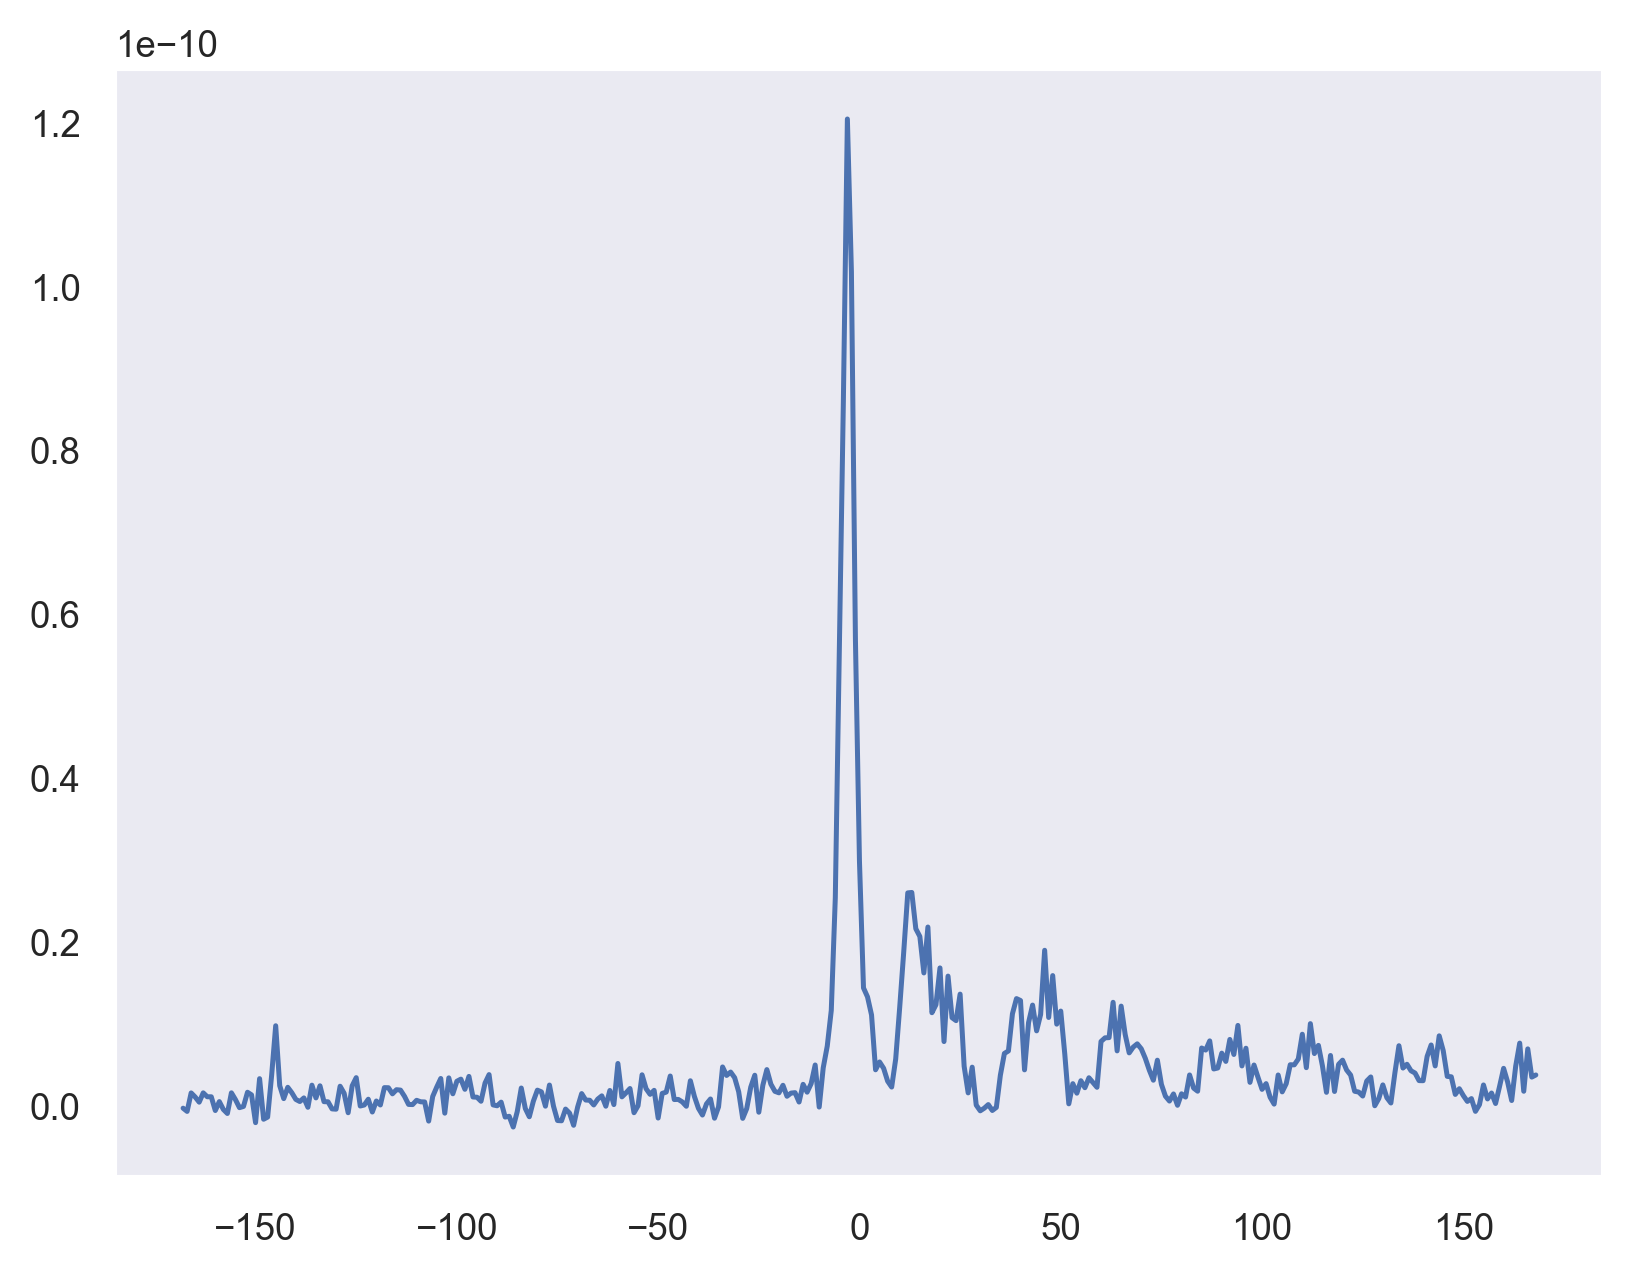

In [29]:
coefs = res.params.filter(like="wind_over_thresh")
coefs.index = np.arange(start_hour, end_hour + 1)

coefs.plot()

Here we can see the diurnal signal in the post-hurricane coefficients, perhaps indicating that the CRR model more accurately reflects the underlying data generating process than the CRD model.

## Milton Analysis

Below this, we assess out-of-sample skill (using Reg 1) in predicting emergency calls from Hurricane Milton. We also produce relevant figures and predictions for a blog post about this exercise.

### Data exploration plots

#### Intro wind and calls figure

In [30]:
m_calls = (
    load_call_data("milton")
    .set_index("pt_dt_minute")
    .groupby("start_h3_r9")
    .call_count.resample("h")
    .sum()
    .sort_index()
)

latlon = m_calls.index.get_level_values("start_h3_r9").map(h3.cell_to_latlng)

valid = (
    gpd.GeoSeries.from_xy(
        latlon.get_level_values(1), latlon.get_level_values(0), crs="EPSG:4326"
    )
    .intersects(storm_buffers["milton"])
    .values
)
m_calls = m_calls[valid]
latlon = latlon[valid]

In [31]:
hres = 6

m_calls_lores = m_calls.groupby(
    [
        m_calls.index.get_level_values("start_h3_r9").map(
            lambda x: h3.cell_to_parent(x, hres)
        ),
        "pt_dt_minute",
    ]
).sum()

pops_lores = all_pops.population.groupby(
    all_pops.index.map(lambda x: h3.cell_to_parent(x, hres))
).sum()

In [32]:
footprint = (
    rio.open_rasterio(
        BytesIO(
            client.live_tcwind_footprint(
                latlon.get_level_values(0).min() - 0.1,
                latlon.get_level_values(0).max() + 0.1,
                latlon.get_level_values(1).min() - 0.1,
                latlon.get_level_values(1).max() + 0.1,
                storm_name="milton",
                storm_year=2024,
            )
        ),
        mask_and_scale=True,
    )
    .squeeze(drop=True)
    .rename("maxs")
    .load()
)
footprint.attrs["long_name"] = "Max 3s gust, median estimate"

2024-11-14 12:39:11,354 - INFO - reaskapi.api_client:151 - querying metryc/live/tcwind/footprint took 1988ms


<Axes: xlabel='hour'>

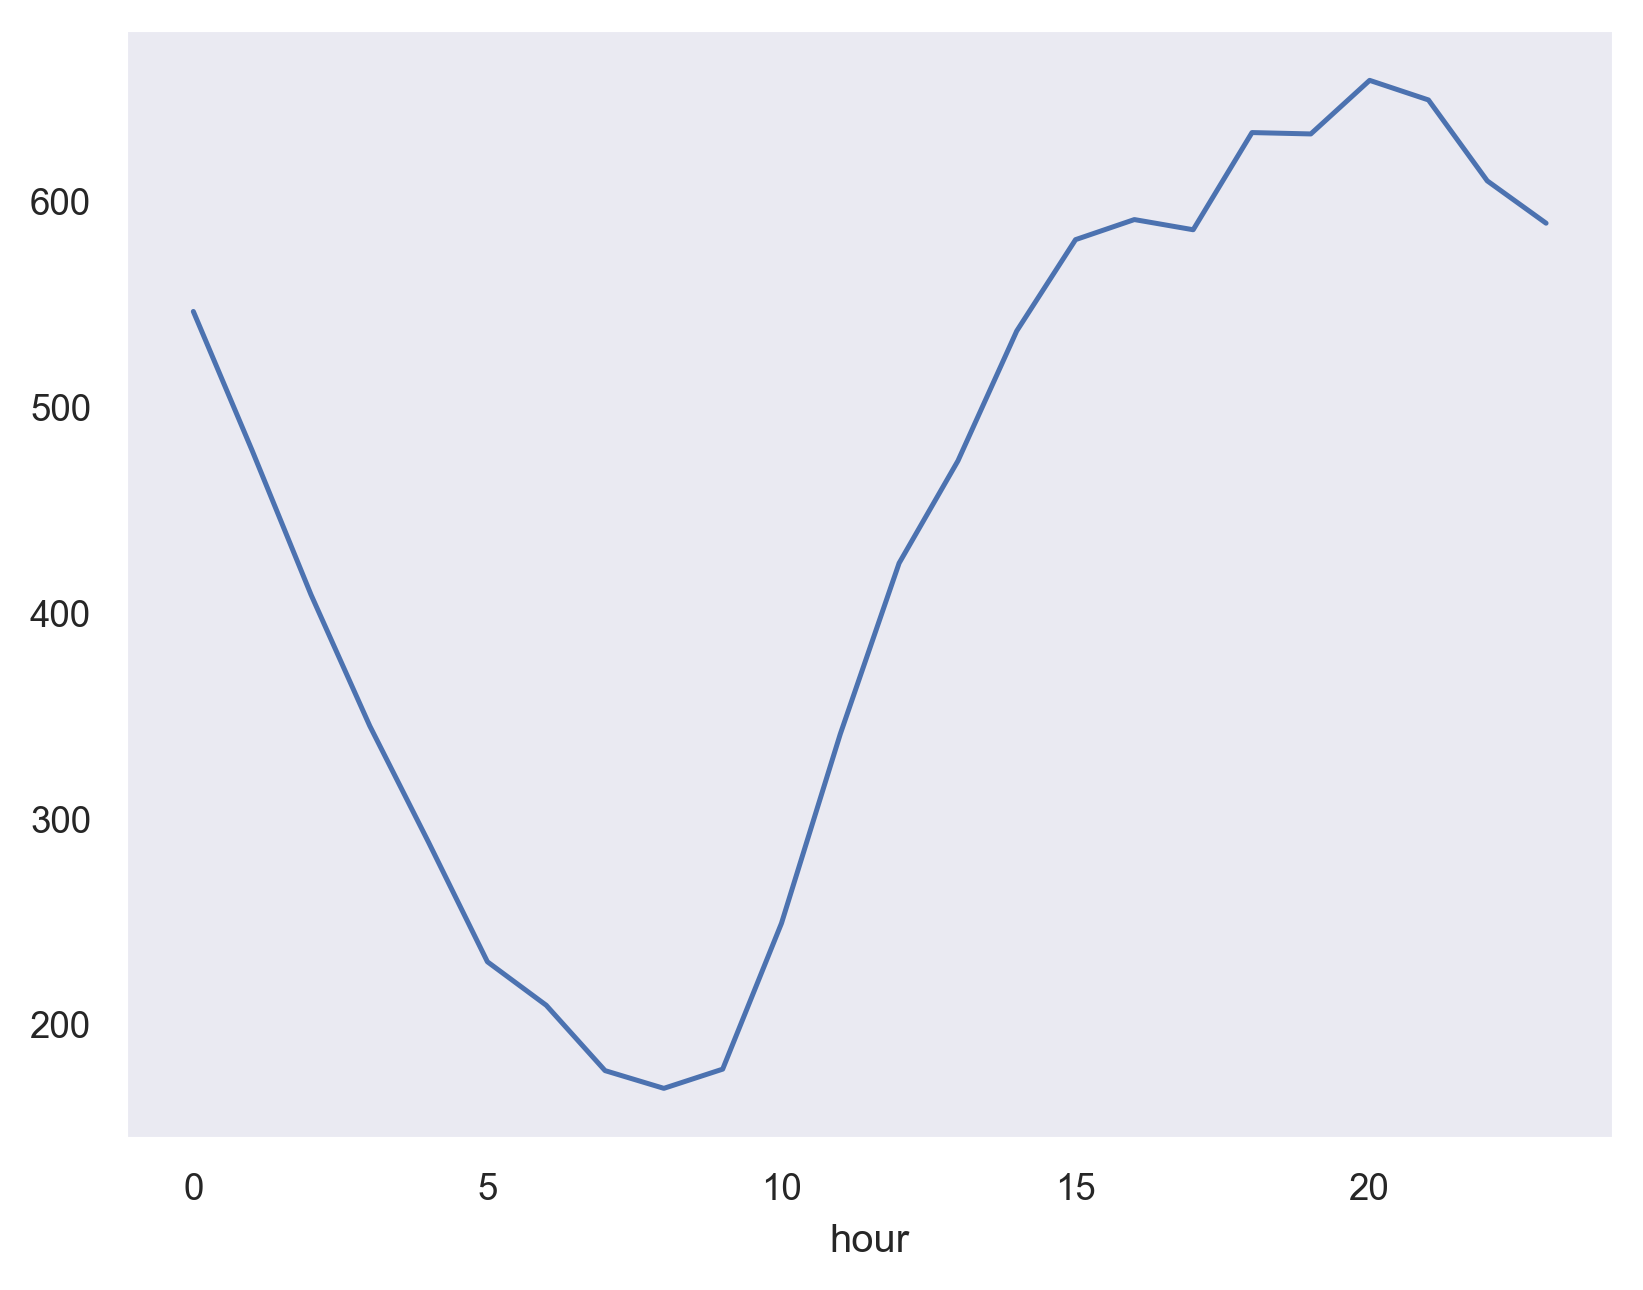

In [33]:
baseline = (
    pd.concat(
        (
            m_calls_lores.loc[idx[:, "09-10-2024T00:00:00":"09-23-2024T23:59:00"]],
            m_calls_lores.loc[idx[:, "09-30-2024T00:00:00":"10-06-2024T23:59:00"]],
        )
    )
    .to_frame()
    .assign(hour=lambda x: x.index.get_level_values("pt_dt_minute").hour)
    .groupby(["start_h3_r9", "hour"])
    .call_count.sum()
    / 21
).rename("baseline_calls")

# Show what a diurnal cycle looks like
baseline.groupby("hour").sum().plot()

#### Spatial Max wind vs. CRR

In [34]:
# ratio of +/- 1 day of landfall
rat1 = (
    (
        m_calls_lores.loc[idx[:, "2024-10-08 23:00:00":"2024-10-10 22:00:00"]]
        .groupby("start_h3_r9")
        .sum()
        / 2
    )
    .to_frame()
    .join(baseline.groupby("start_h3_r9").sum())
)
rat1 = rat1.call_count / rat1.baseline_calls

rat1 = (rat1[rat1.notnull() & ~np.isinf(rat1)].rename("call_ratio") - 1) * 100

locs = rat1.index.map(h3.cell_to_boundary).map(
    lambda x: shp.Polygon([(i[1], i[0]) for i in x])
)
rat1 = (
    gpd.GeoDataFrame(
        rat1.to_frame(),
        geometry=gpd.GeoSeries(
            locs, crs="EPSG:4326", index=rat1.index, name="geometry"
        ),
    )
    .join(pops_lores)
    .fillna({"population": 0})
)

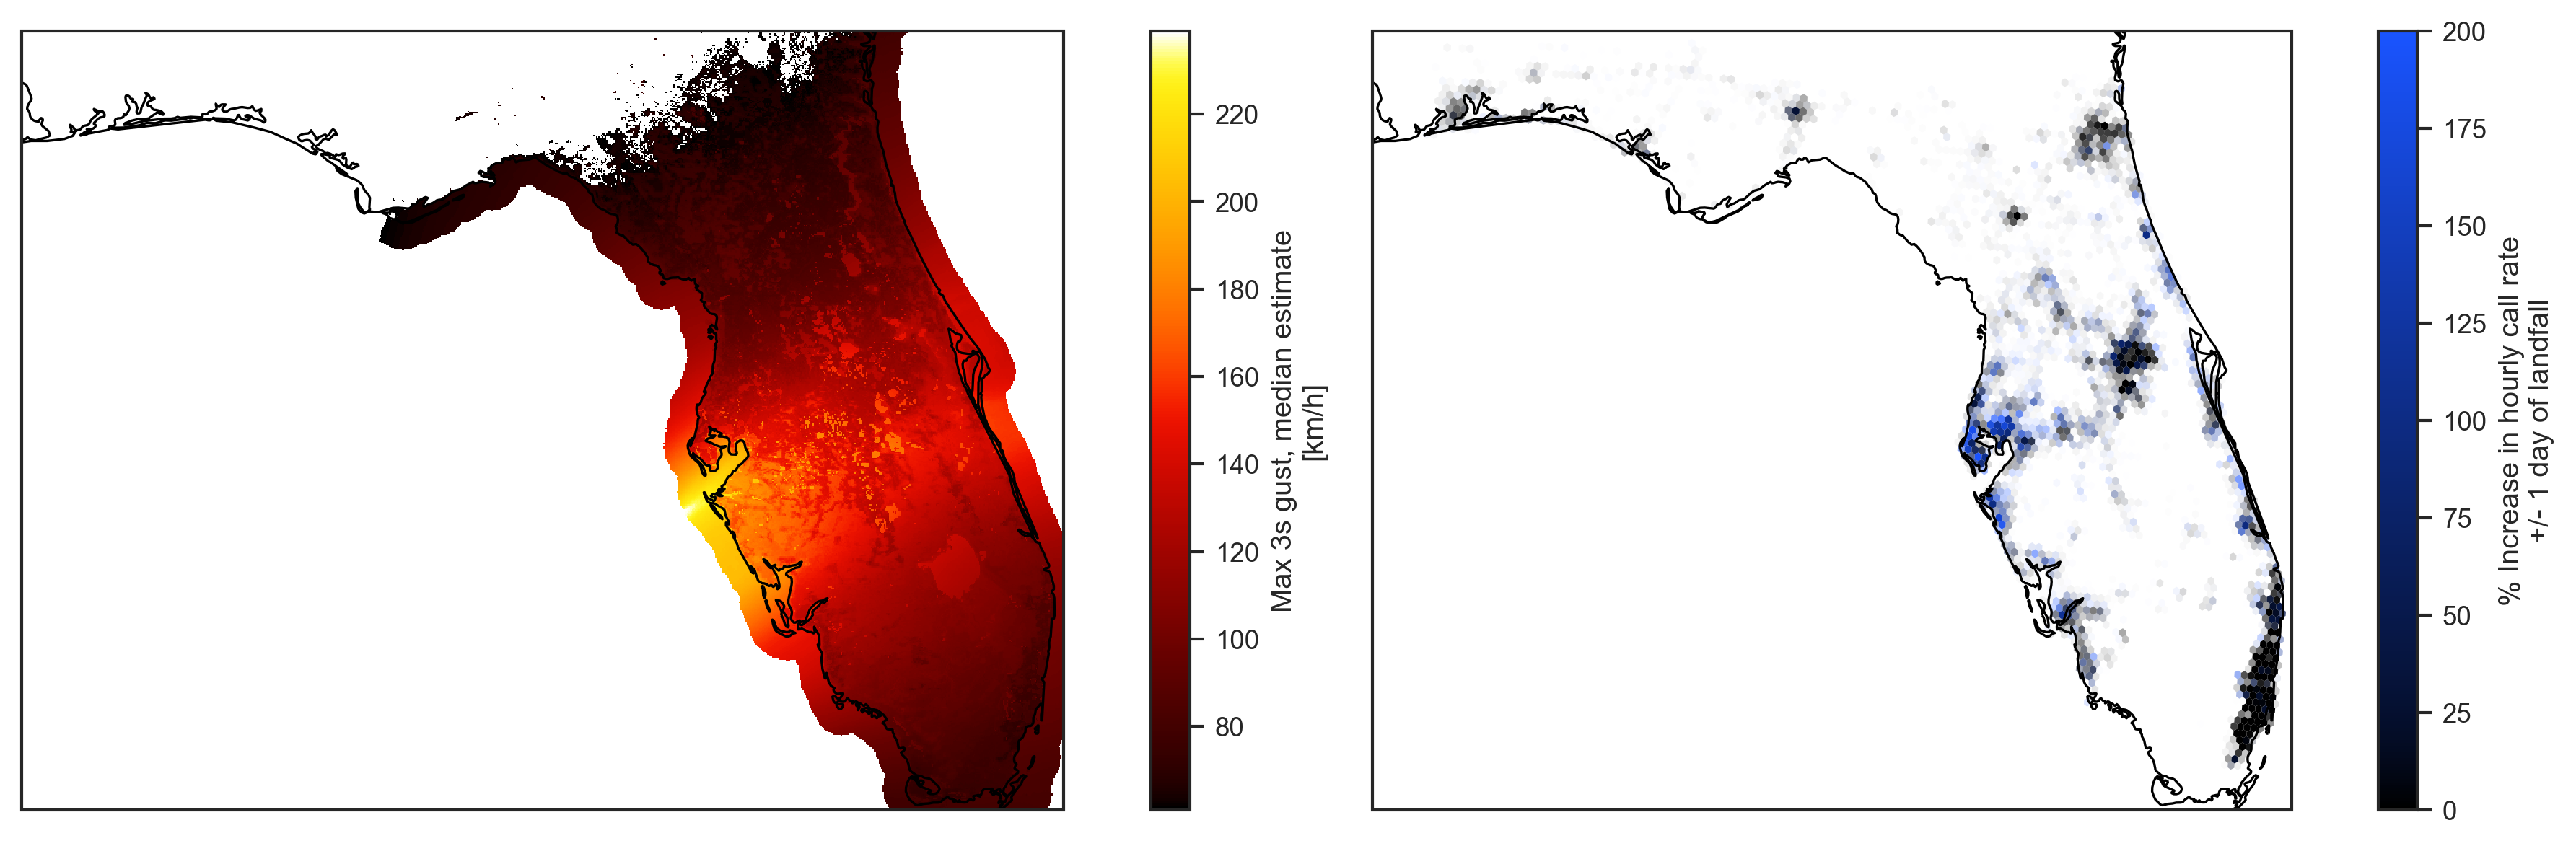

In [35]:
with sns.axes_style("white"):
    fig, axs = plt.subplots(
        1,
        2,
        figsize=(14, 4),
        subplot_kw={"projection": ccrs.PlateCarree()},
        sharex=True,
        sharey=True,
        tight_layout=True,
    )

    footprint.plot(x="x", y="y", ax=axs[0], cmap="cet_fire")
    axs[0].coastlines()
    axs[0].set_title(None)
    rat1.plot(
        "call_ratio",
        cmap="cet_kb",
        alpha=(rat1.population / rat1.population.quantile(0.95)).clip(0, 1),
        ax=axs[1],
        legend=True,
        linewidth=0,
        vmin=0,
        vmax=200,
        legend_kwds={"label": "% Increase in hourly call rate\n+/- 1 day of landfall"},
    )
    axs[1].coastlines()
    axs[1].set_title(None)

for kind in ["png", "pdf"]:
    fig.savefig(FIG_DIR / f"wind-and-calls-overview.{kind}")

### Call rate time series by low/high winds

In [36]:
milton_data_ldf = load_and_align_data("milton", "ldf")

Processing milton...


2024-11-14 12:39:25,498 - INFO - reaskapi.api_client:151 - querying metryc/live/tcwind/footprint took 1887ms


...Total hexagons dropped due to 0 population: 2987 (1%)
...Total calls dropped due to 0 population: 3388 (1%)


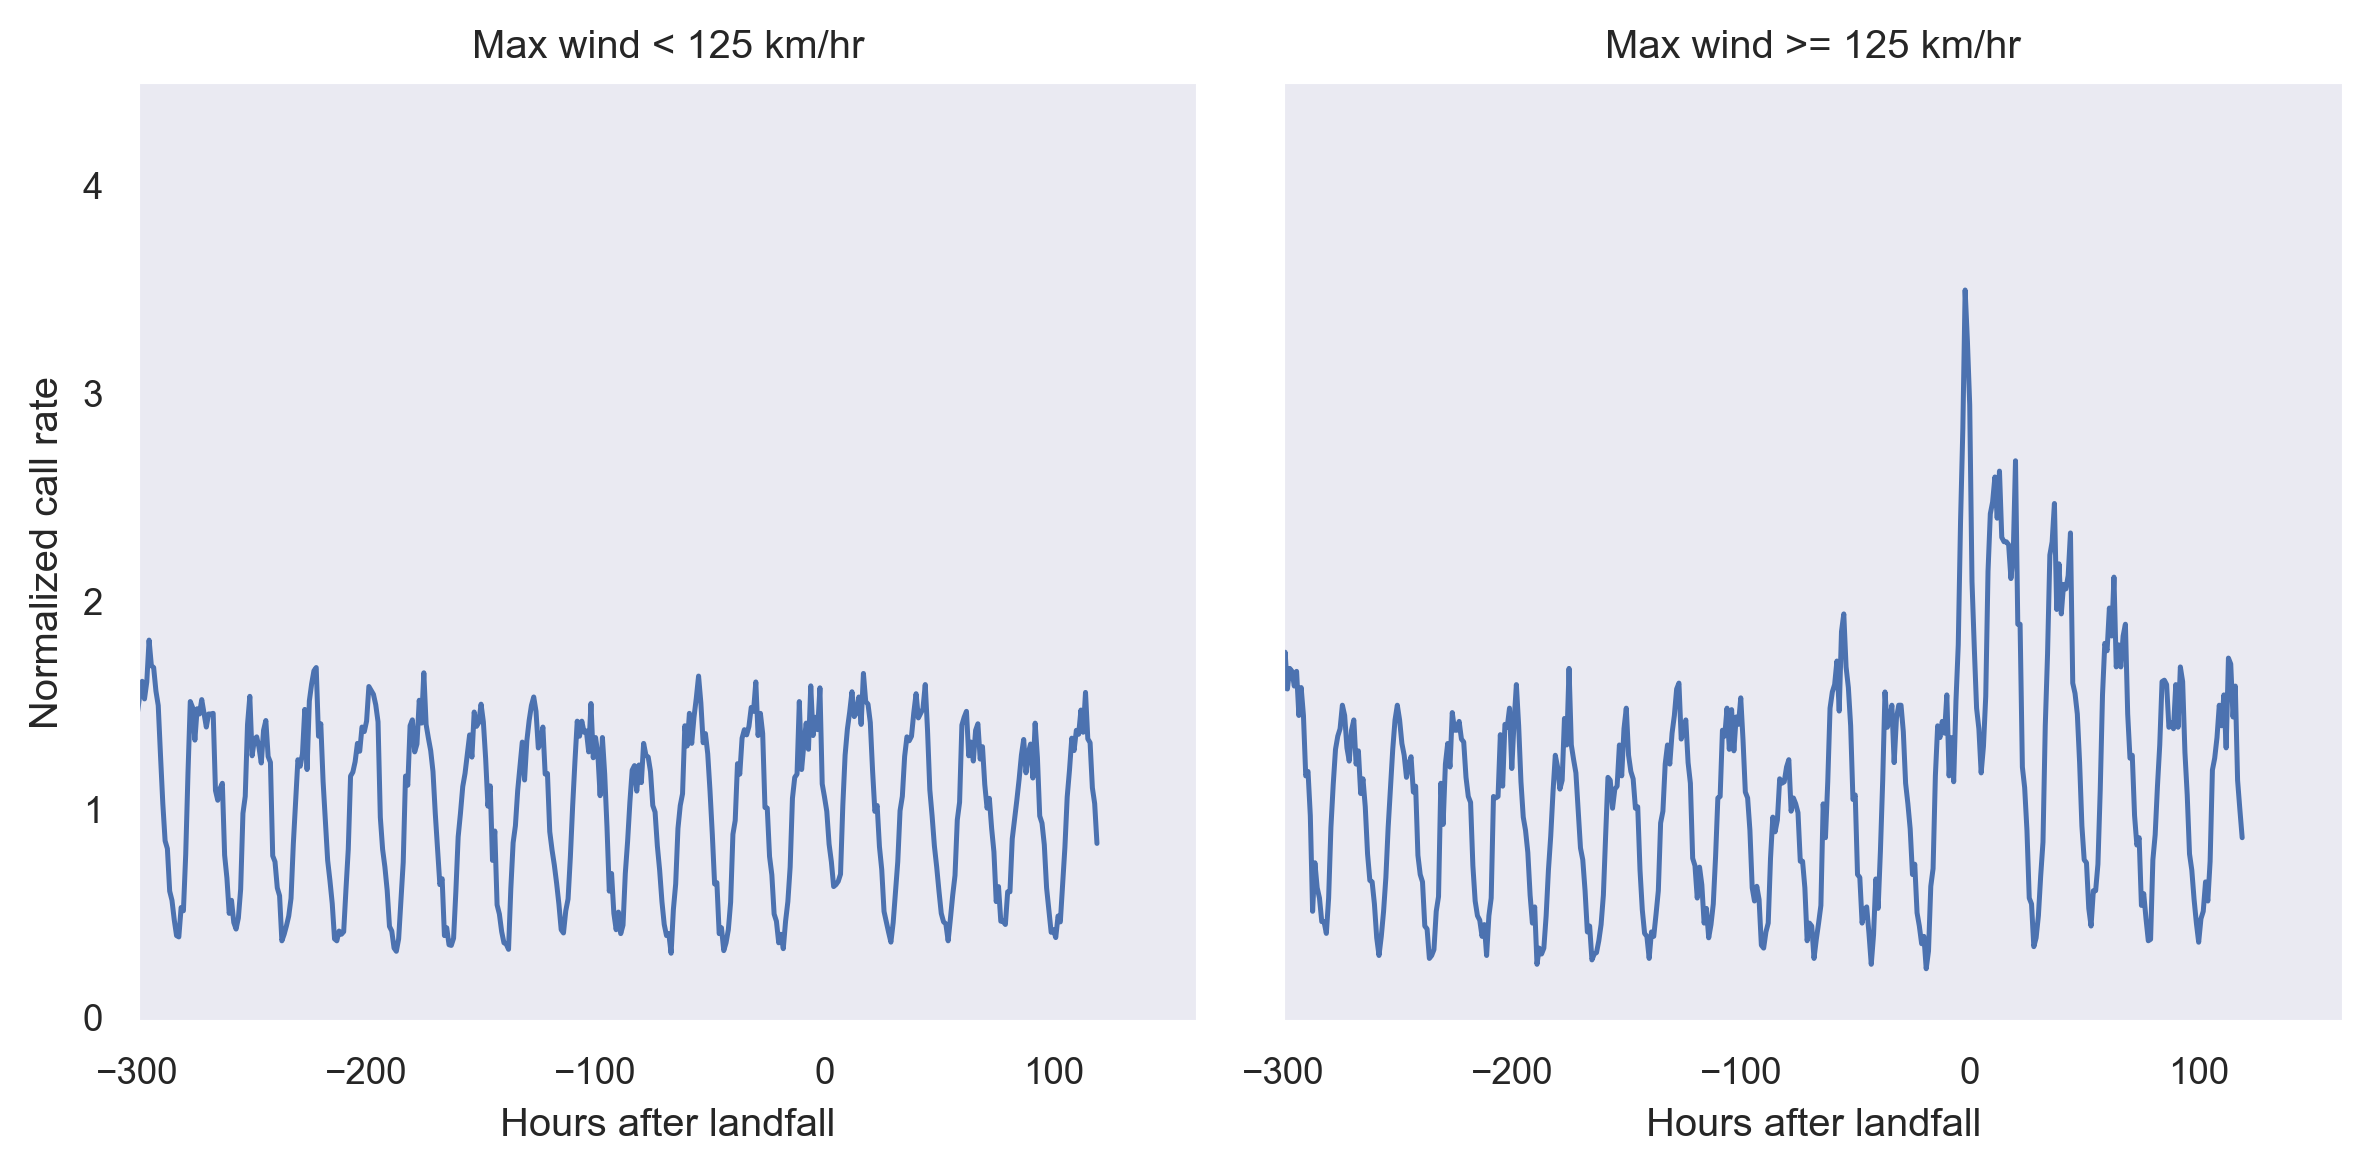

In [37]:
thresh = 125
min_hrs = -300


def plot_timeseries(df, title, ax, xmin=None):
    """Plot time series of call rate."""
    call_count = df.groupby("hour").call_count.sum()
    call_count /= call_count.mean()
    call_count.plot(
        xlabel="Hours after landfall",
        ylabel="Normalized call rate",
        title=f"Max wind {title} km/hr",
        xlim=(xmin, None),
        ax=ax,
    )


fig, axs = plt.subplots(
    1, 2, figsize=(8, 4), sharex=True, sharey=True, tight_layout=True
)
plot_timeseries(
    milton_data_ldf.loc[milton_data_ldf.index.get_level_values("maxs") < thresh],
    f"< {thresh}",
    axs[0],
    xmin=min_hrs,
)
plot_timeseries(
    milton_data_ldf.loc[milton_data_ldf.index.get_level_values("maxs") >= thresh],
    f">= {thresh}",
    axs[1],
    xmin=min_hrs,
)
for kind in ["png", "pdf"]:
    fig.savefig(FIG_DIR / f"calls-timeseries.{kind}")

### Bin scatter of +/- 1 day of landfall CRR vs. winds

In [38]:
m_data_nearest = (
    load_and_align_data("milton", "nearest")
    .groupby(["storm", "hour", "maxs"])
    .sum()
    .droplevel("storm")
    .loc[-768:71]
)

# hour of day relative to closest landfall time
# (will be used to account for temporal oscillations)
m_daily_calls = (
    m_data_nearest.call_count.groupby(
        [m_data_nearest.index.get_level_values("hour") // 24, "maxs"]
    )
    .sum()
    .rename_axis(index={"hour": "day"})
)

m_daily_calls = m_daily_calls.to_frame().assign(
    dow=m_daily_calls.index.get_level_values("day") % 7
)

m_baseline_calls_per_day = pd.concat(
    (m_daily_calls.loc[:-19], m_daily_calls.loc[-10:-4])
)
m_baseline_calls_per_day = (
    m_baseline_calls_per_day.groupby(["dow", "maxs"]).call_count.sum() / 3
).rename("baseline_call_rate")

Processing milton...


2024-11-14 12:39:37,482 - INFO - reaskapi.api_client:151 - querying metryc/live/tcwind/footprint took 2233ms


...Total hexagons dropped due to 0 population: 2985 (1%)
...Total calls dropped due to 0 population: 3388 (1%)


In [39]:
bin_size = 1
binned_calls = (
    m_daily_calls.groupby(
        [
            "day",
            m_daily_calls.index.get_level_values("maxs") // bin_size * bin_size
            + bin_size / 2,
        ]
    )
    .sum()
    .loc[-1:0, "call_count"]
)
binned_baseline = m_baseline_calls_per_day.groupby(
    [
        "dow",
        m_baseline_calls_per_day.index.get_level_values("maxs") // bin_size * bin_size
        + bin_size / 2,
    ]
).sum()

call_rat = (
    normalize_calls(
        binned_calls,
        binned_baseline,
        fillna=None,
        fillinf=1 / 21,
    )
    .groupby("maxs")
    .mean()
)
call_rat["call_ratio"] = (call_rat.call_ratio - 1) * 100
call_rat = call_rat[call_rat.call_ratio.notnull() & ~np.isinf(call_rat.call_ratio)]

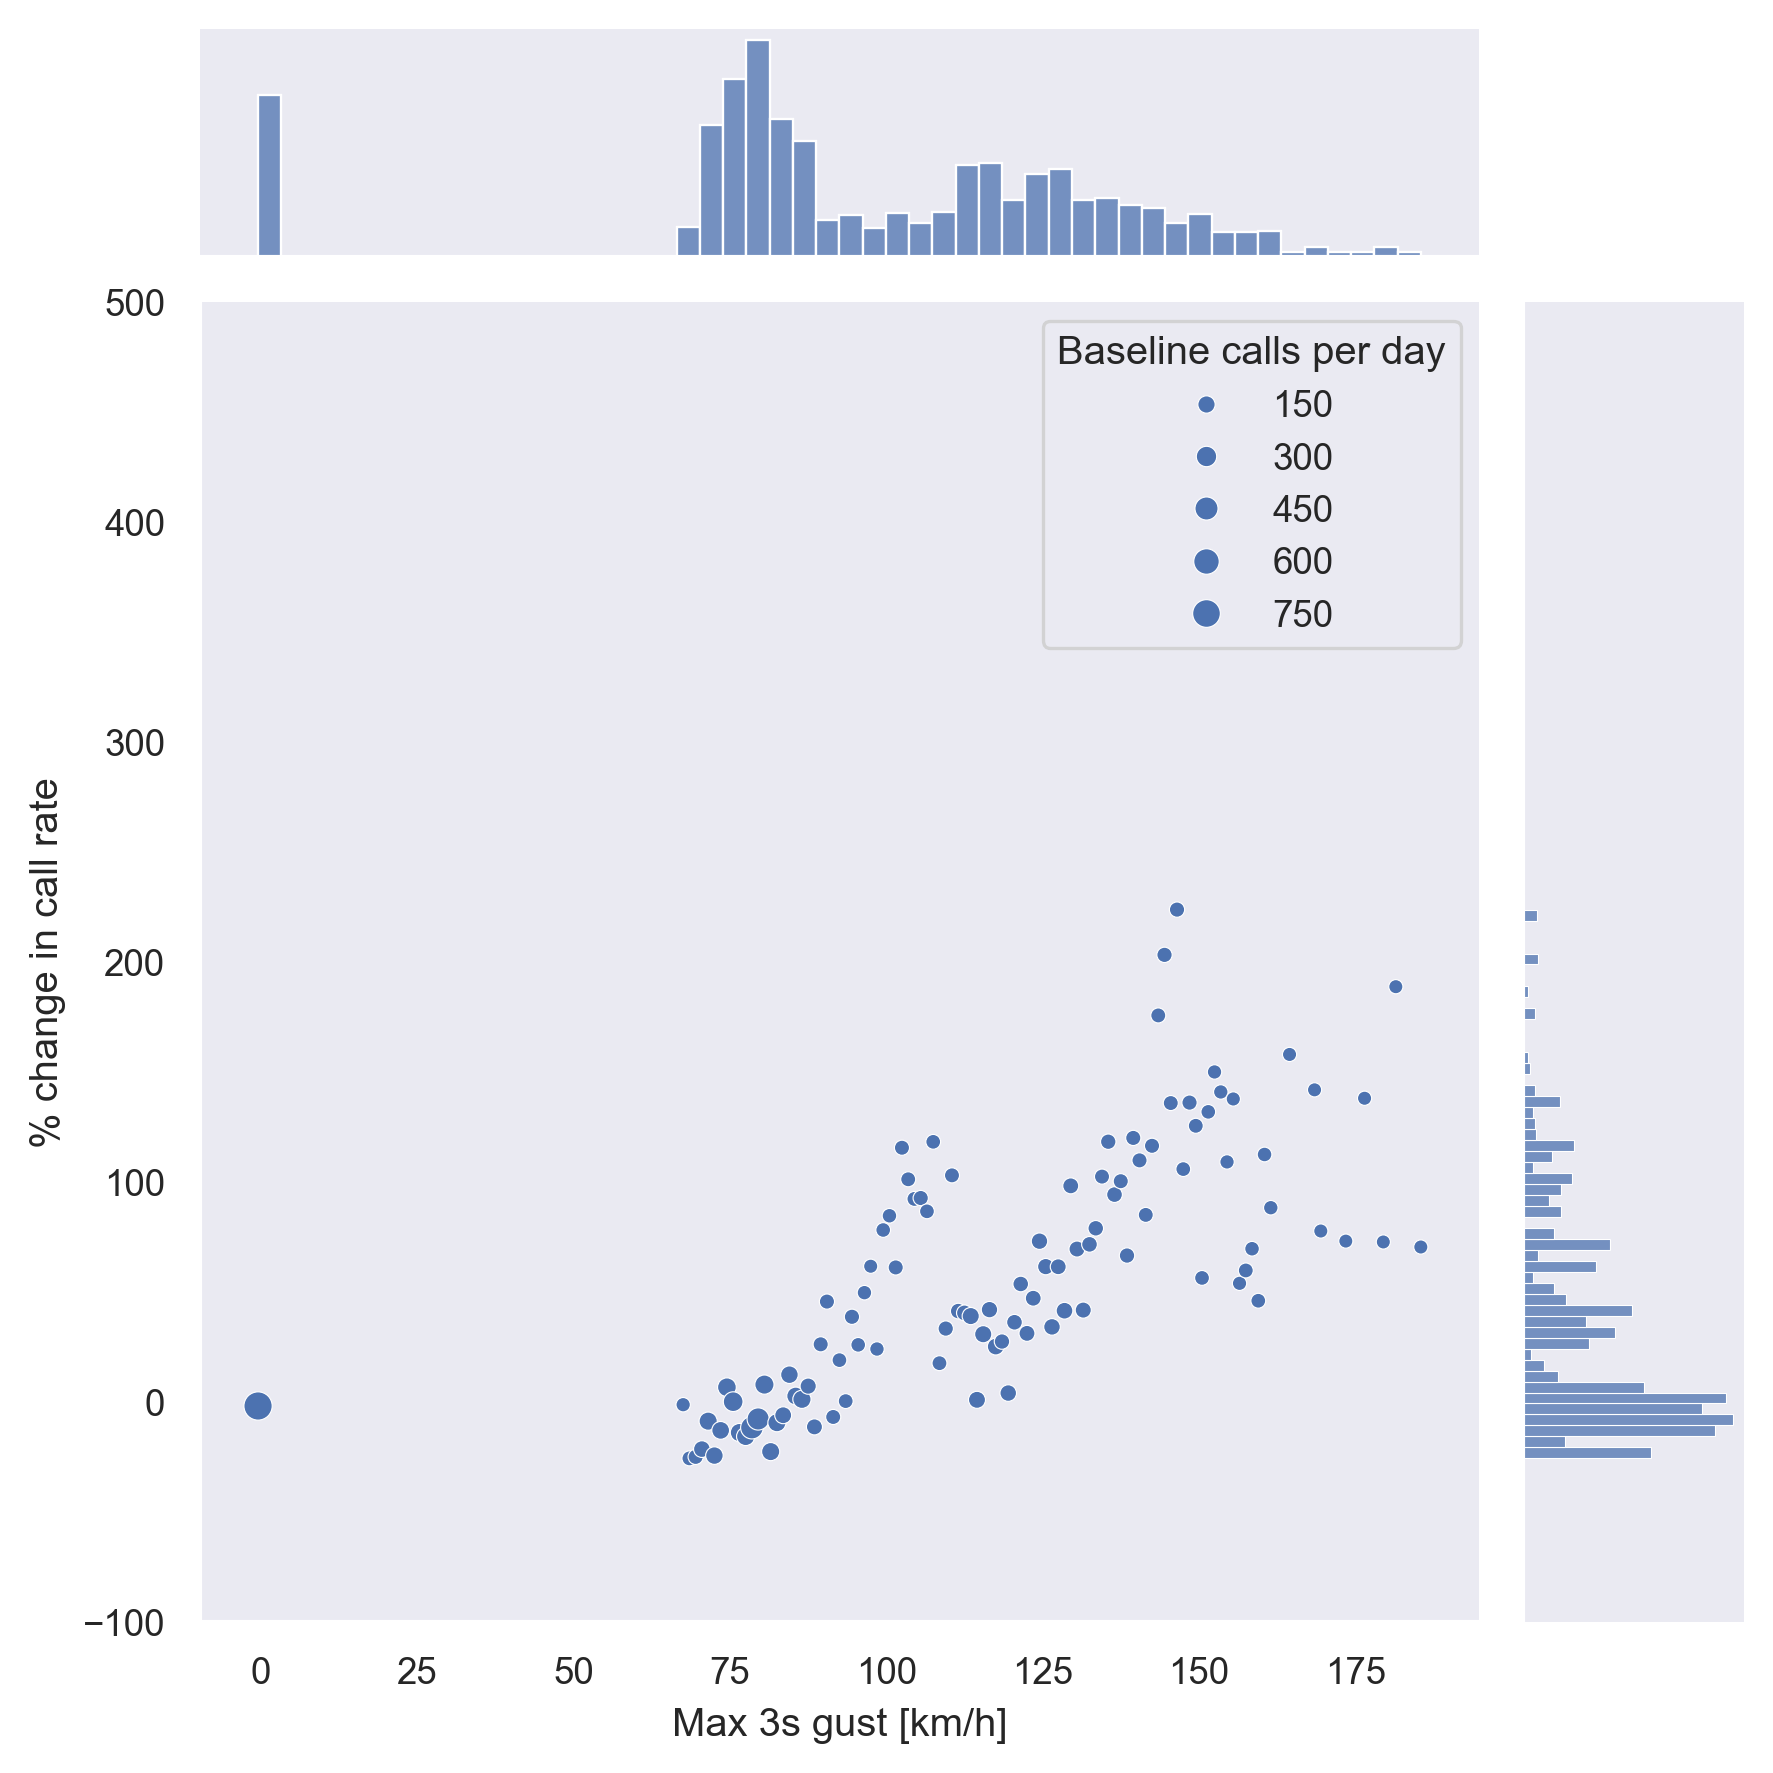

In [40]:
plot_data = call_rat[call_rat.baseline > 20].reset_index()

fig = sns.jointplot(
    plot_data,
    x="maxs",
    y="call_ratio",
    ylim=(-100, 500),
    size=plot_data.baseline.rename("Baseline calls per day"),
    marginal_kws={"weights": plot_data.baseline, "bins": 50},
).set_axis_labels(xlabel="Max 3s gust [km/h]", ylabel="% change in call rate")

for kind in ["pdf", "png"]:
    fig.savefig(FIG_DIR / f"change-vs-wind.{kind}")

### Model/Prediction plots
#### Wind speed coefficient over time from Reg 1

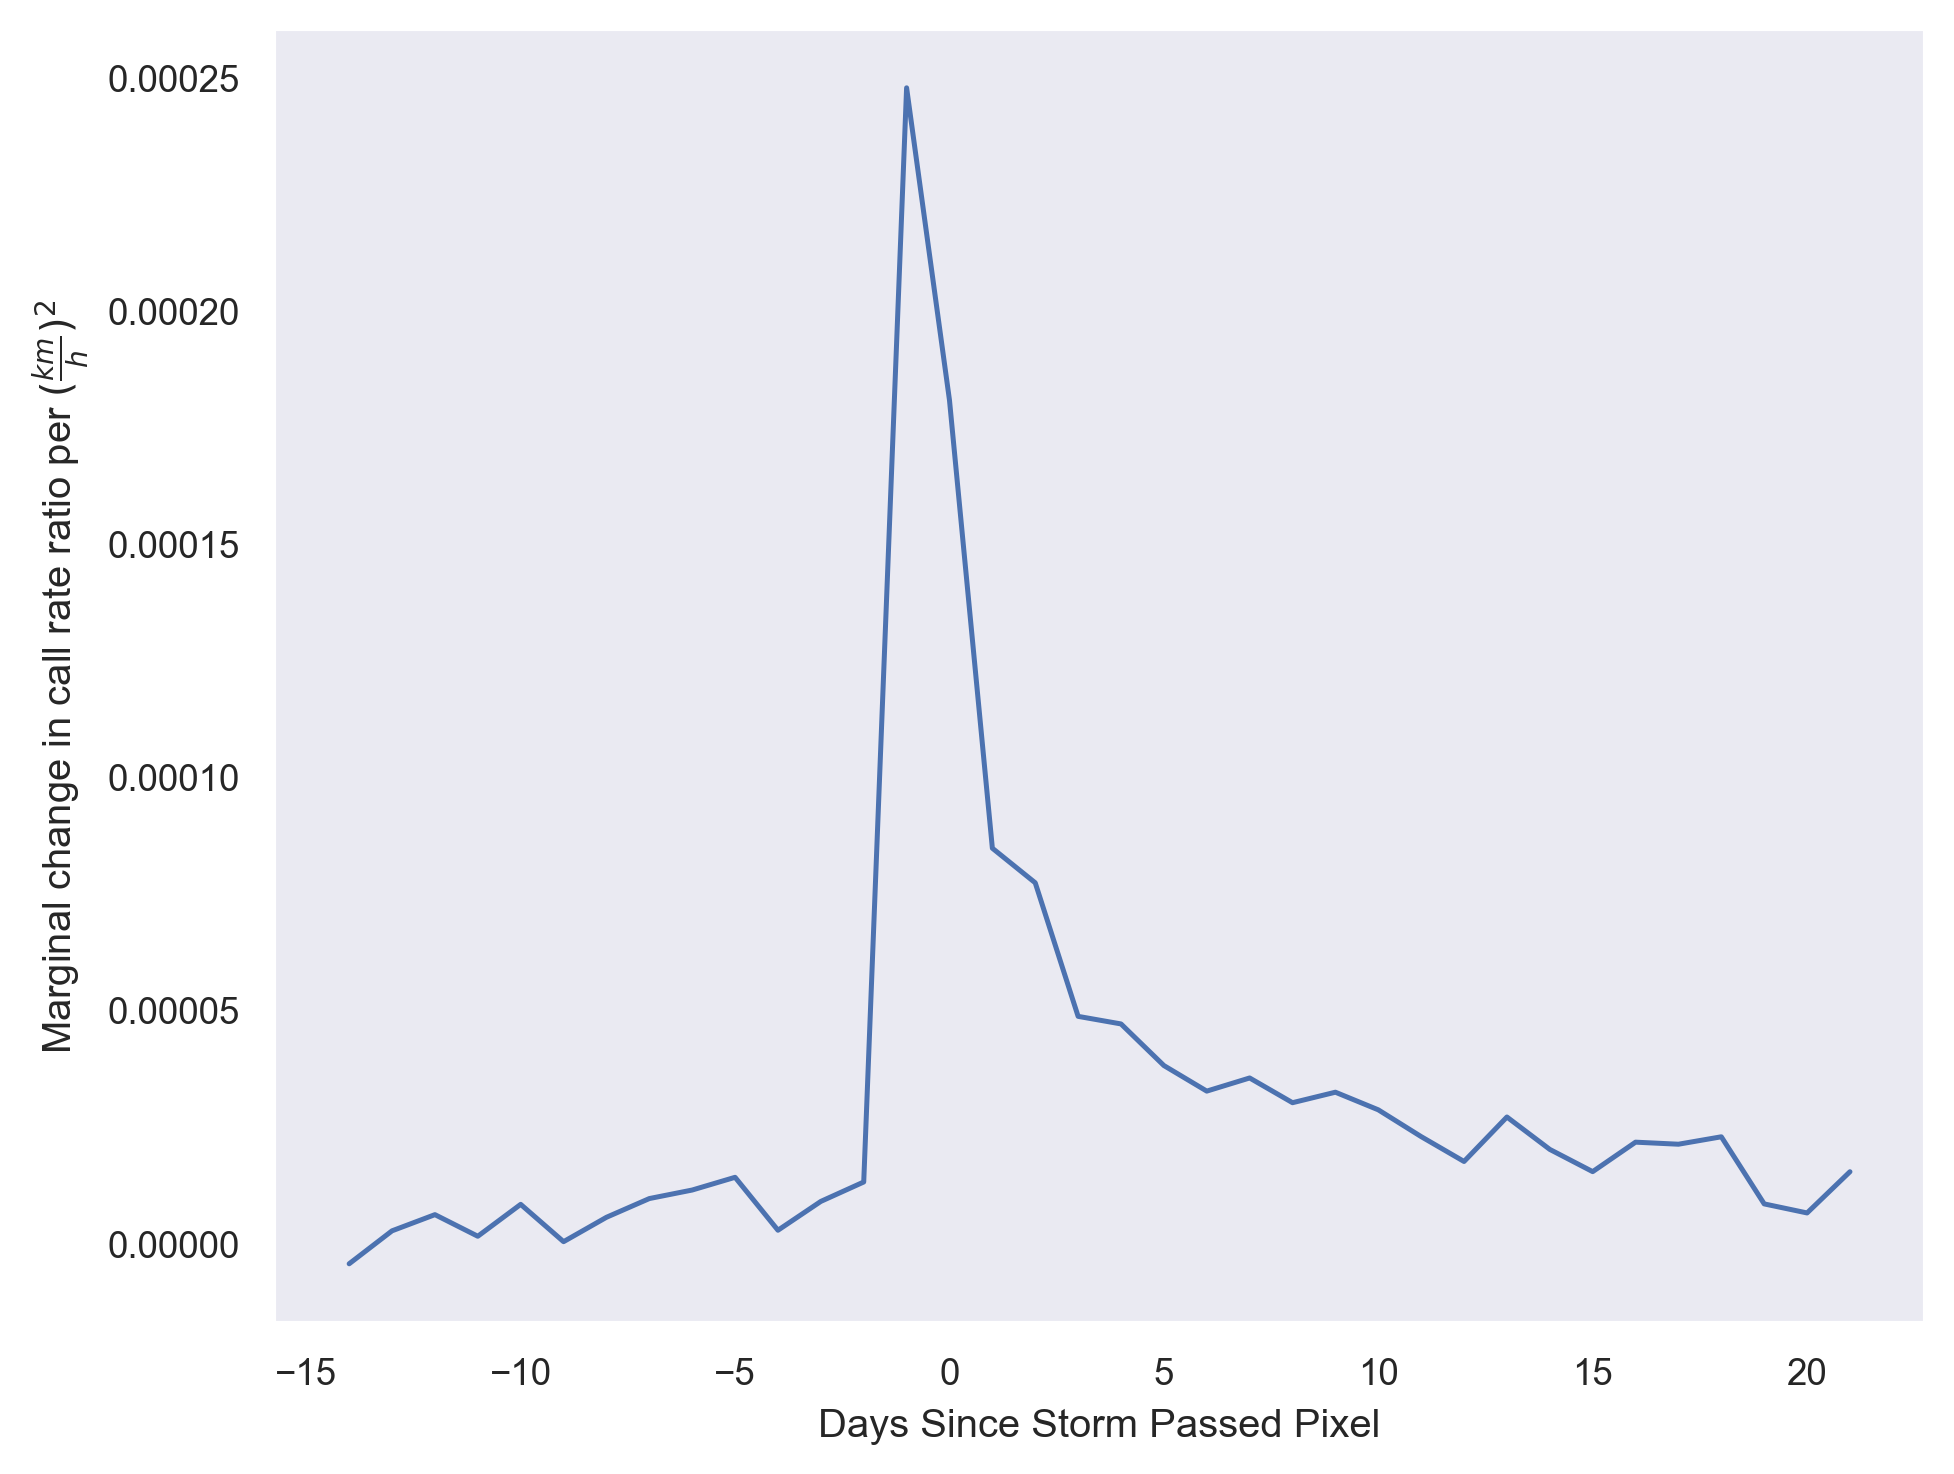

In [41]:
coefs = m_res.params.filter(like="wind_over_thresh").rename("coef")
coefs.index = np.arange(-14, 22)
fig, ax = plt.subplots(layout="constrained")
ax = coefs.plot(
    xlabel="Days Since Storm Passed Pixel",
    ylabel=r"Marginal change in call rate ratio per $(\frac{km}{h})^2$",
    ax=ax,
)
for kind in ["png", "pdf"]:
    fig.savefig(FIG_DIR / f"coefs.{kind}")

#### Prediction time series comparison

In [42]:
m_metryc = (
    load_and_align_data("milton", TIMING_KIND, grouper="h3")
    .droplevel("storm")
    .loc[-744:95]
)

Processing milton...


2024-11-14 12:39:50,035 - INFO - reaskapi.api_client:151 - querying metryc/live/tcwind/footprint took 1935ms


...Total hexagons dropped due to 0 population: 2985 (1%)
...Total calls dropped due to 0 population: 3388 (1%)


In [43]:
# hour/day of week relative to closest landfall time (will be used to account for temporal oscillations)
m_daily_calls = (
    m_metryc.groupby([m_metryc.index.get_level_values("hour") // 24, "h3"])
    .agg({"call_count": "sum", "maxs": "first"})
    .rename_axis(index={"hour": "day"})
)

dow = m_daily_calls.index.get_level_values("day") % 7

this = m_daily_calls.assign(dow=dow)
m_baseline_calls_per_day = pd.concat((this.loc[:-18], this.loc[-10:-4]))
m_baseline_calls_per_day = (
    m_baseline_calls_per_day.groupby(["dow", "h3"]).call_count.sum() / 3
)

In [44]:
reg_df = normalize_calls(
    m_daily_calls.call_count, m_baseline_calls_per_day, how="ratio", fillinf=1 / 21
)
reg_df["call_ratio"] -= 1

# time slice
reg_df = reg_df.loc[-3:]

reg_df = reg_df.join(all_pops.population, on="h3").join(
    m_daily_calls.groupby(("h3")).maxs.first(), on="h3"
)

reg_df = reg_df[reg_df.call_ratio.notnull() & ~np.isinf(reg_df.call_ratio)]
reg_df = reg_df.assign(
    has_wind=reg_df.maxs > 0,
    wind_over_thresh=(reg_df.maxs - 61).clip(0, np.inf),
    observed=(reg_df.call_ratio + 1) * reg_df.baseline,
).reset_index()

In [45]:
preds = reg_df.assign(predicted=(m_res.predict(reg_df) + 1) * reg_df.baseline)

predlocs = preds.h3.apply(h3.cell_to_latlng)
preds = preds.assign(
    county=gpd.sjoin(
        gpd.GeoSeries.from_xy(
            predlocs.str[1], predlocs.str[0], crs="EPSG:4326"
        ).to_frame(),
        counties,
        predicate="intersects",
        how="left",
    ).NAME
)

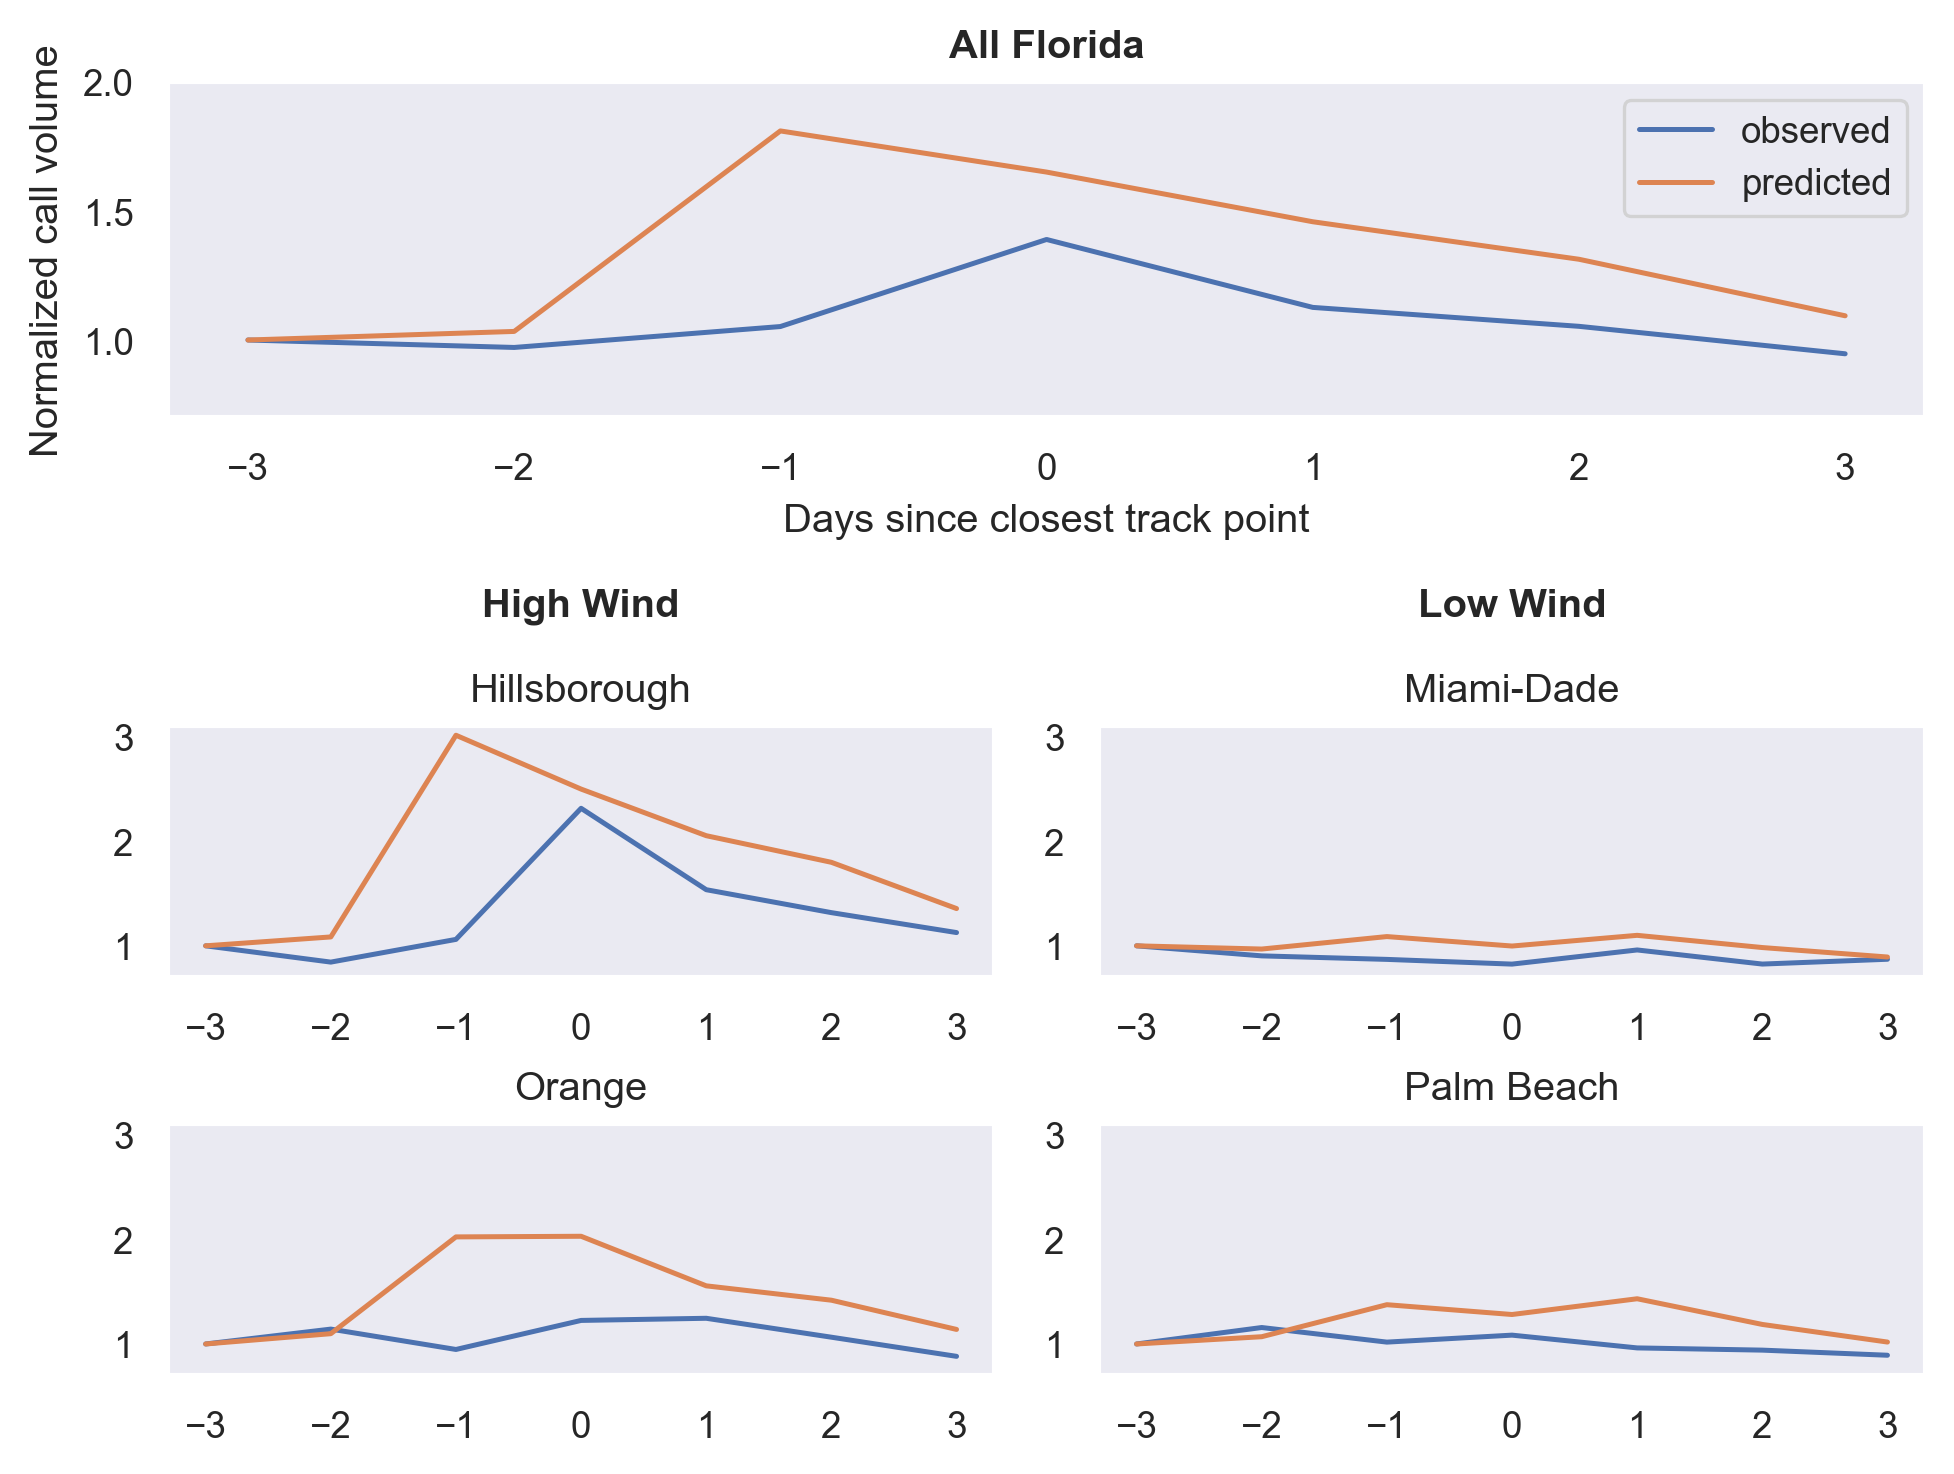

In [46]:
plot_data = preds[["county", "day", "observed", "predicted"]]

fig = plt.figure(layout="constrained")
gs = GridSpec(4, 4, figure=fig, height_ratios=[2, 0.5, 1.5, 1.5])
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[2, :2])
ax3 = fig.add_subplot(gs[3, :2])
ax4 = fig.add_subplot(gs[2, 2:])
ax5 = fig.add_subplot(gs[3, 2:])

ax_l = fig.add_subplot(gs[1, :2])
ax_r = fig.add_subplot(gs[1, 2:])

this_data = plot_data.groupby("day")[["observed", "predicted"]].sum()
this_data = this_data.div(this_data.iloc[0], axis=1)
this_data.plot(ax=ax1, ylim=(0.7, 2), ylabel="Normalized call volume")
ax1.set_title("All Florida", weight="bold")
ax1.set_xlabel("Days since closest track point")
for cty, ax in [
    ("Hillsborough", ax2),
    ("Orange", ax3),
    ("Miami-Dade", ax4),
    ("Palm Beach", ax5),
]:
    this_data = (
        plot_data[plot_data.county == cty]
        .groupby("day")[["observed", "predicted"]]
        .sum()
    )
    this_data = this_data.div(this_data.iloc[0], axis=1)
    this_data.plot(ax=ax, legend=False, xlabel="", title=cty, ylim=(0.7, 3.1))

ax_l.text(0.5, 0.5, "High Wind", va="center", ha="center", weight="bold")
ax_l.axis("off")
ax_r.text(0.5, 0.5, "Low Wind", va="center", ha="center", weight="bold")
ax_r.axis("off")

for kind in ["png", "pdf"]:
    fig.savefig(FIG_DIR / f"predicted-timeseries.{kind}")

#### Prediction vs. obs +/- 1 day spatial comparison

In [47]:
fl_counties = counties[counties.GEOID.astype(str).str[:2] == "12"]
county_rats = gpd.GeoDataFrame(
    (
        preds.groupby(["day", "county"])[["baseline", "predicted", "observed"]]
        .sum()
        .loc[-1:1]
        .groupby("county")
        .sum()
        / 2
    ).join(fl_counties.set_index("NAME").geometry),
    geometry="geometry",
)
county_rats[["predicted", "observed"]] = (
    county_rats[["predicted", "observed"]].div(county_rats.baseline, axis=0) - 1
) * 100
county_rats = county_rats.drop(columns="baseline").dropna(subset="geometry")
assert county_rats.index.is_unique

In [48]:
county_pops = (
    gpd.sjoin(all_pops, fl_counties, predicate="intersects", how="right")
    .groupby("NAME")
    .population.sum()
)

In [49]:
county_rats = county_rats.join(county_pops)

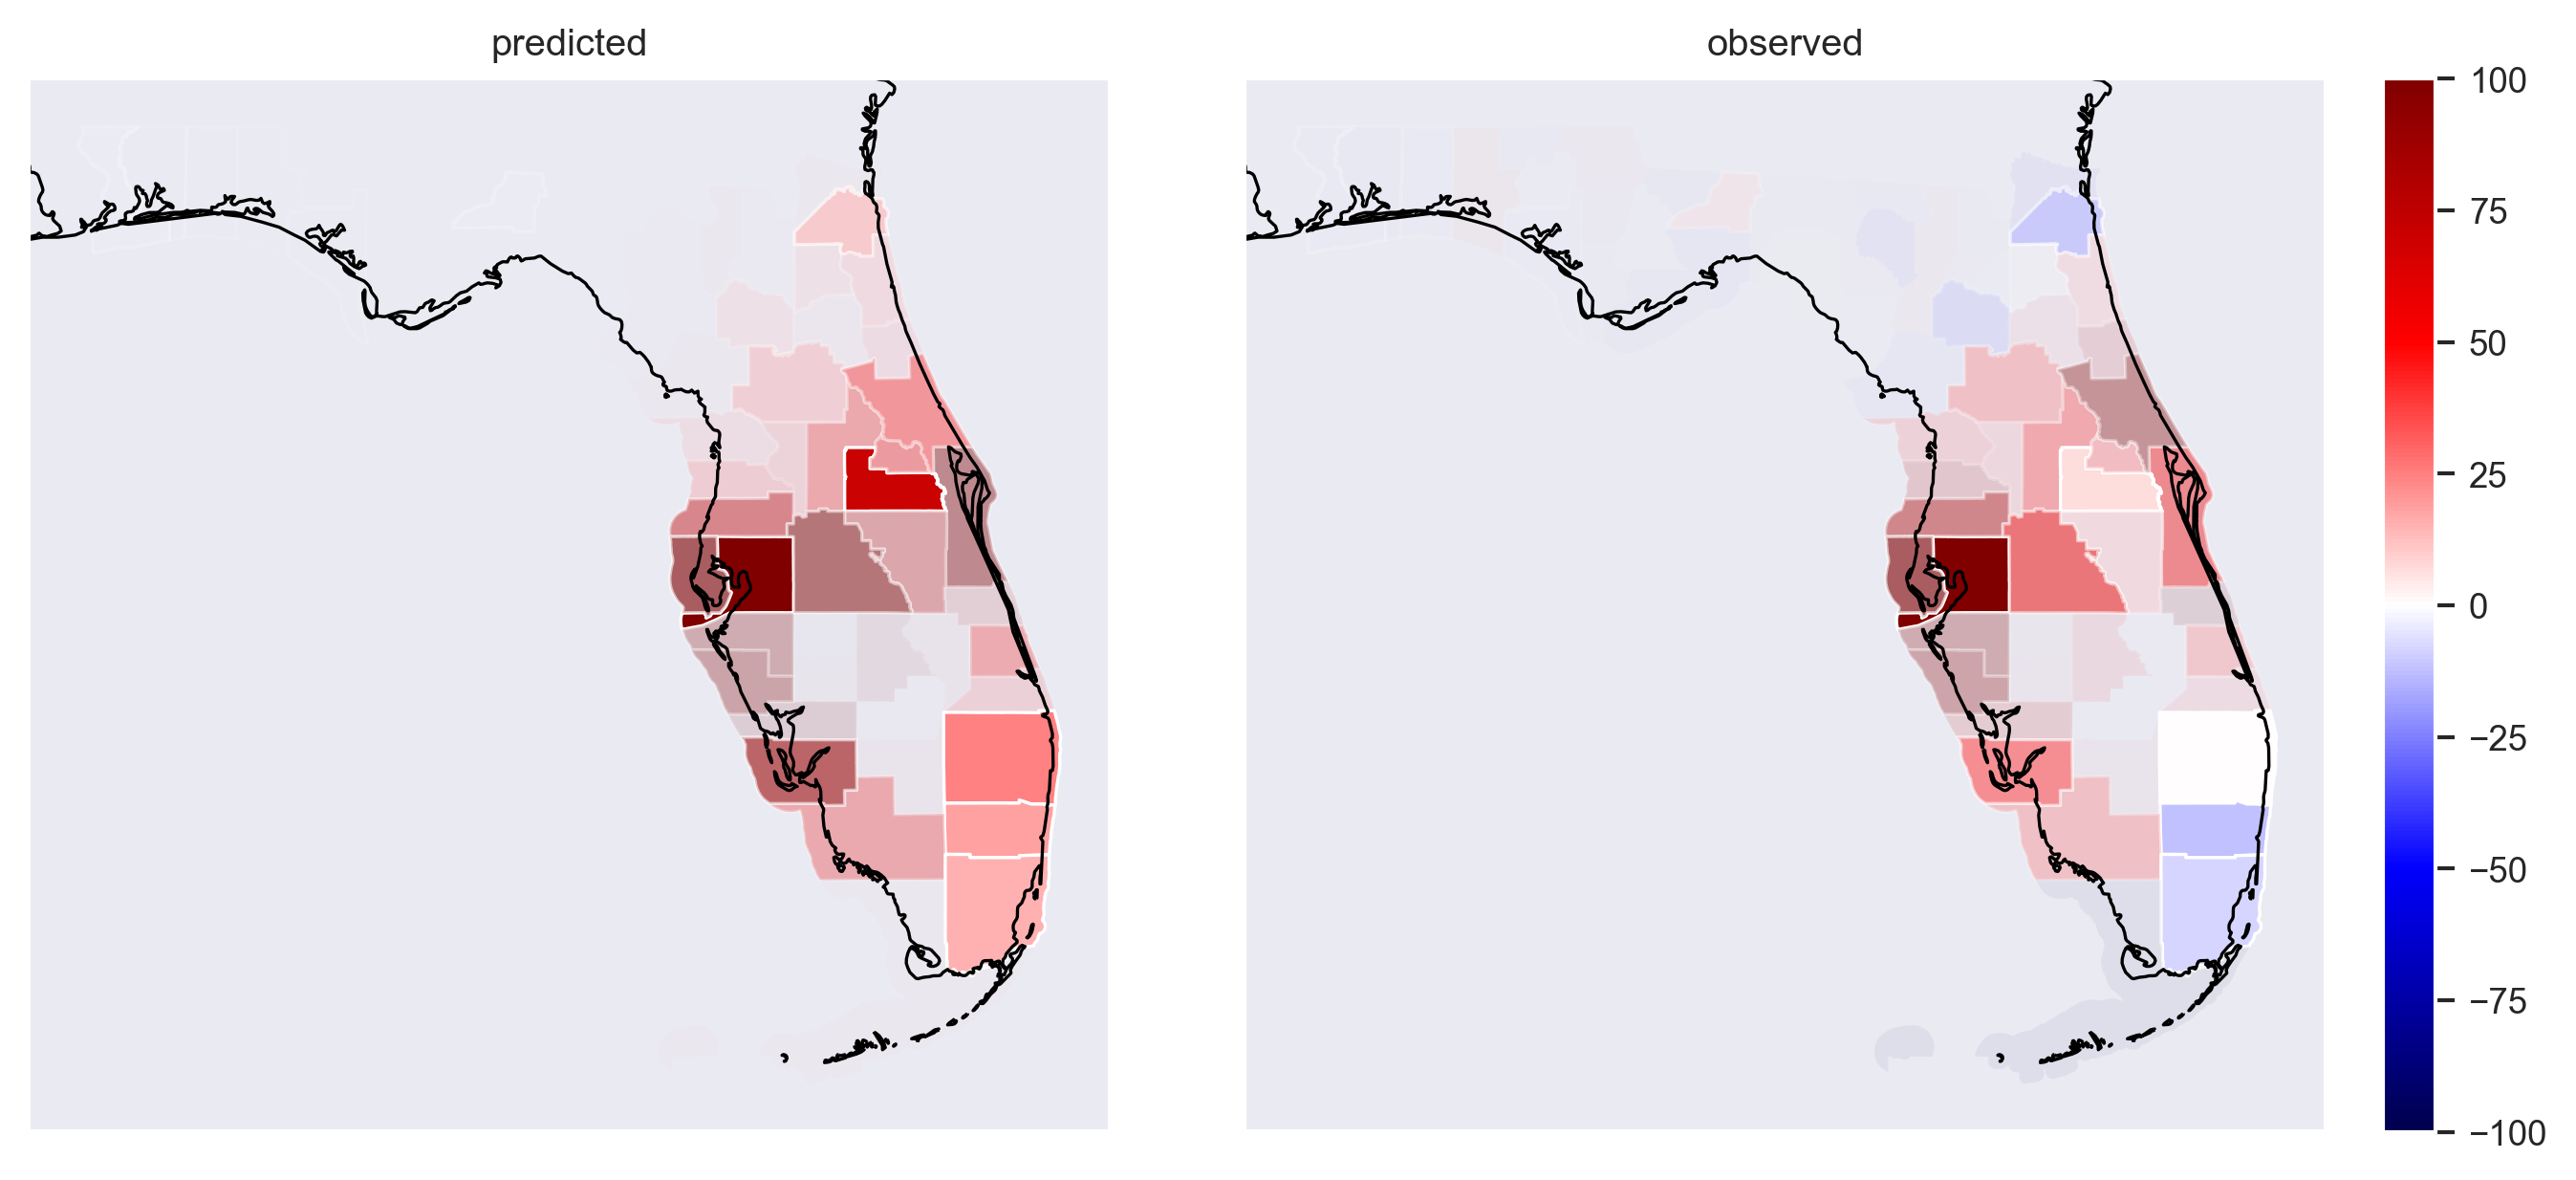

In [50]:
fig, ax = plt.subplots(
    1,
    2,
    figsize=(9, 4),
    subplot_kw={"projection": ccrs.PlateCarree()},
    layout="constrained",
)
for ix, col in enumerate(["predicted", "observed"]):
    county_rats.plot(
        column=col,
        alpha=(county_rats.population / county_rats.population.quantile(0.95)).clip(
            0, 1
        ),
        legend=ix == 1,
        cmap="seismic",
        vmin=-100,
        vmax=100,
        ax=ax[ix],
    )
    ax[ix].set_title(col)
    ax[ix].coastlines()

for kind in ["png", "pdf"]:
    fig.savefig(FIG_DIR / f"pred-obs-map.{kind}")